In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# Explore ArcticGRO data and clean for use elsewhere

LJB downloaded ArcticGRO discharge data Nov 2021, for all available sites.

Notebook aims:

* Look at all ArcticGRO discharge data. Are there data gaps? If gaps are small, interpolate to get daily data.
* For two rivers, Kolyma and Pechora, have two sites with Q data on the same river. For these: merge into one time series by patching gaps in one site using values estimated using (a) a regression between the two sites (if possible), or (b) area-scaled values from the other site:

    * For **Kolyma**, the two discharge stations on the river are merged to make one series at Kolymskoe.
    * For **Pechora**. Oksino is the downstream station, but has much less monitoring data than Ust-Tsilma, further upstream. Area-scale Ust-Tsilma to get a patched series for Oksino.
    
* Truncate to the period of interest for BEST-Siberian marine modelling (1980-2019). Also use this time period for comparing with ArcticGRO chemistry data and deriving QC regressions (at the time of download, Feb 2022, there wasn't much chemistry data in 2020+, and the data were all preliminary). 
* Calculate a monthly time series of mean discharge (m3/s)

Output: cleaned and filled daily and monthly data, one site per river. Gaps still present where these were large.

**Still to do/consider**

* Monthly series indexing - what do marine modellers do with monthly data? Retain daily datetime, or switch to just month? Currently have a full datetime index with day-month-year, and **right closed values** (so monthly mean for Jan is stored against 31st of Jan).

# User input

In [2]:
# Location of input data
in_q_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/raw_download'

# Folders to save output
q_graph_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/plots'
q_cleaned_daily_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'
define_season_df_fpath = r'../output/define_q_season_df.csv'

# Truncate data to these years (inclusive)
st_yr = 1980
end_yr = 2019

# Rivers with multiple sampling sites
multi_site_rivs = ['Pechora', 'Kolyma']

In [3]:
file_list = os.scandir(in_q_folder)
q_dict = {}  # Key: river name, returns df of Q
q_site_dict = {}  # Key: (river, site), returns df of Q for rivs with multiple sites
riv_list = []

# Read in raw Q data, truncate to desired time period, save in dict
for item in file_list:
    if item.is_file():  # Otherwise was getting ipython checkpoints too

        q_df = pd.read_excel(item,
                             usecols="E,F",
                             index_col=0,
                             parse_dates=True)

        q_df = q_df.loc['%s-01-01' % st_yr:'%s-12-31' % end_yr]

        riv_name = item.name.split('_')[0]
        samp_location = item.name.split('_')[1]

        # If river name is Yenisei, rename to Yenisey
        if riv_name == "Yenisei":
            riv_name = "Yenisey"

        # Make unique list of river names for later looping
        if riv_name not in riv_list:
            riv_list.append(riv_name)

        # Add Q data to dictionary, unless riv has multiple sampling sites.
        # In that case, it needs special treatment before it is added to dict (done below)
        if riv_name not in multi_site_rivs:
            q_dict[riv_name] = q_df
        else:
            q_site_dict[(riv_name, samp_location)] = q_df
        print("Finished reading in %s" % riv_name)

Finished reading in Onega
Finished reading in Pur
Finished reading in Kolyma
Finished reading in Yana
Finished reading in Lena
Finished reading in Nadym
Finished reading in Ob
Finished reading in Pechora
Finished reading in Yukon
Finished reading in Olenek
Finished reading in Mezen
Finished reading in Indigirka
Finished reading in Yenisey
Finished reading in Kolyma
Finished reading in Pechora
Finished reading in Mackenzie
Finished reading in NorthernDvina


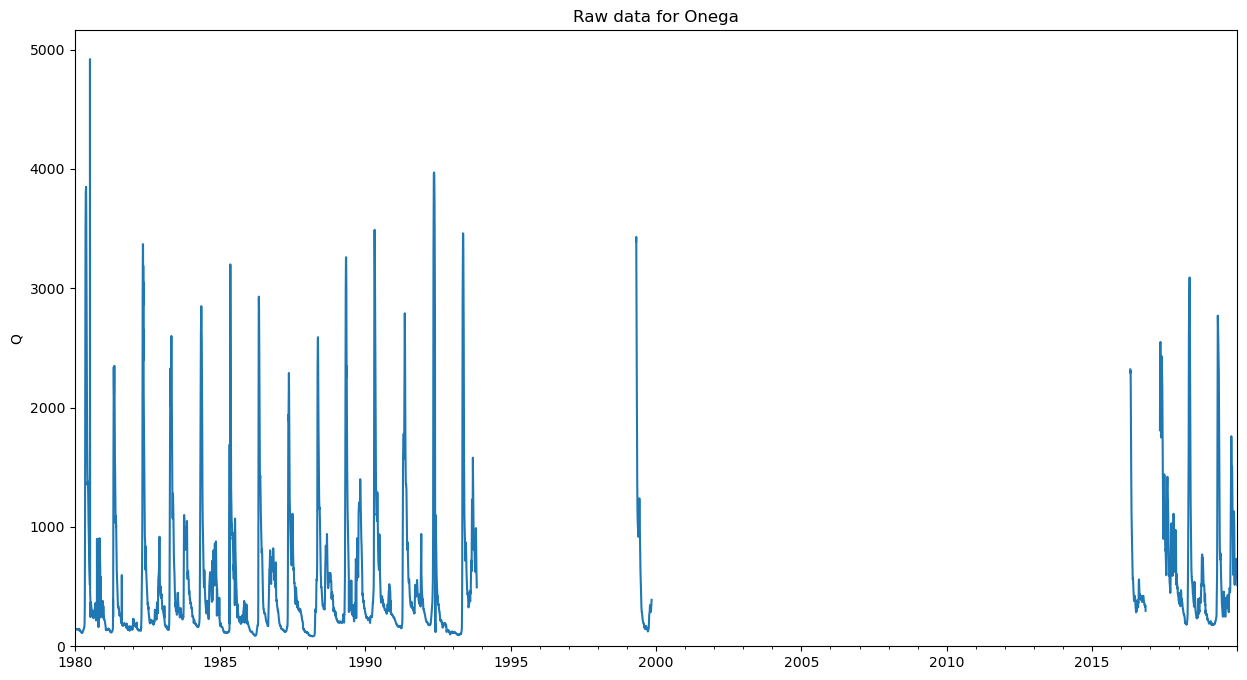

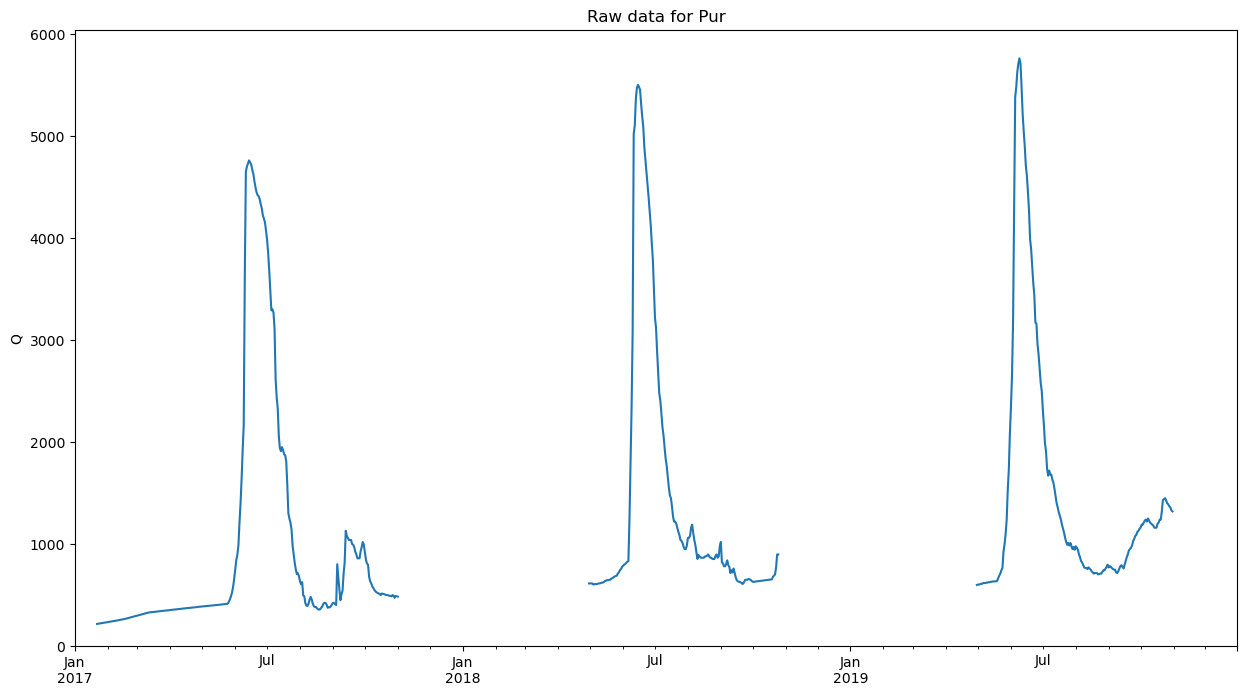

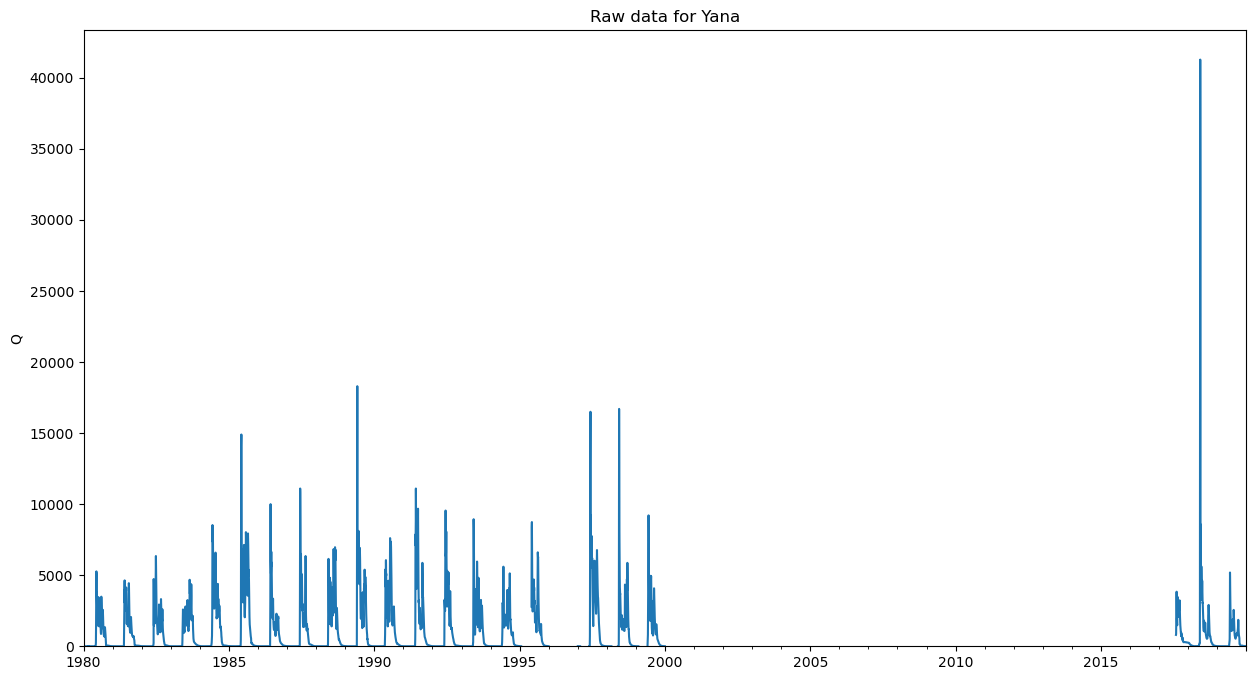

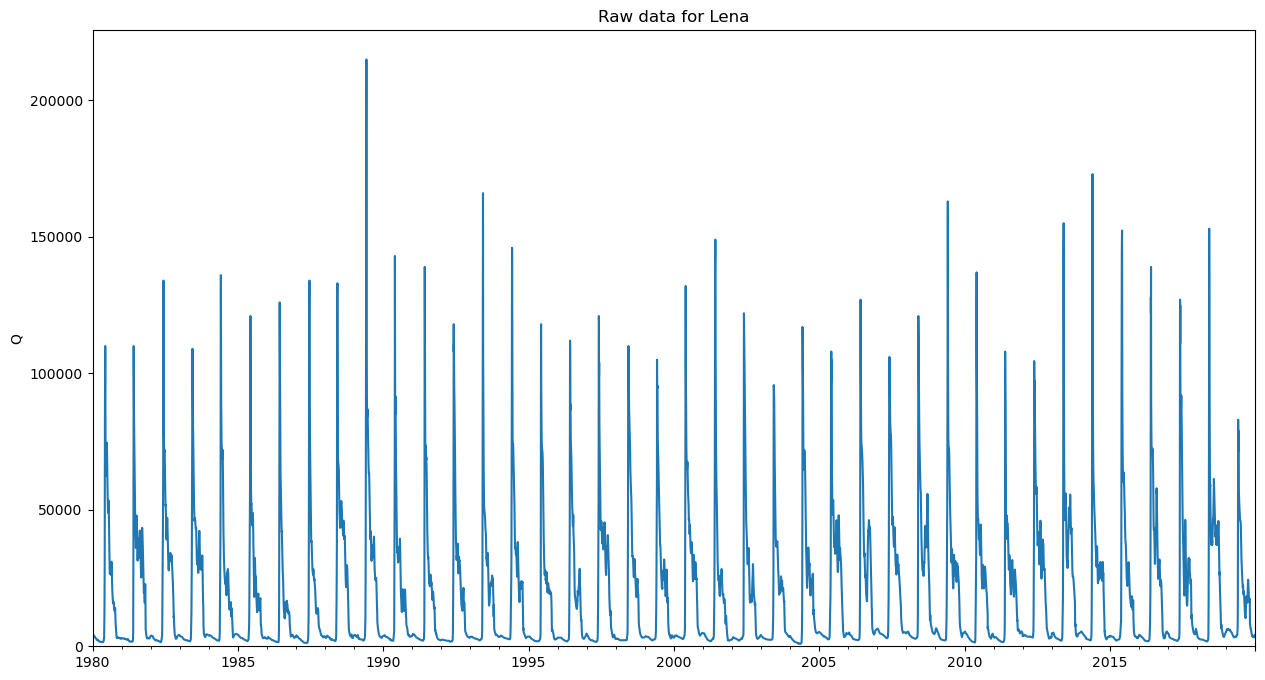

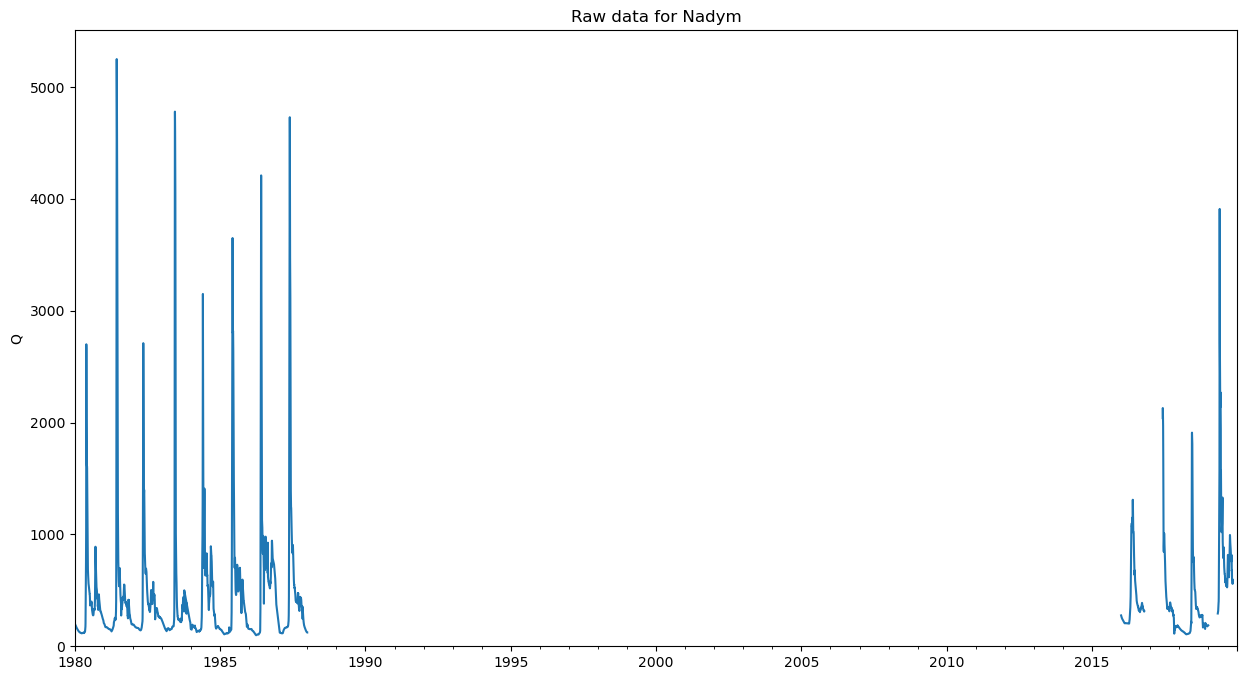

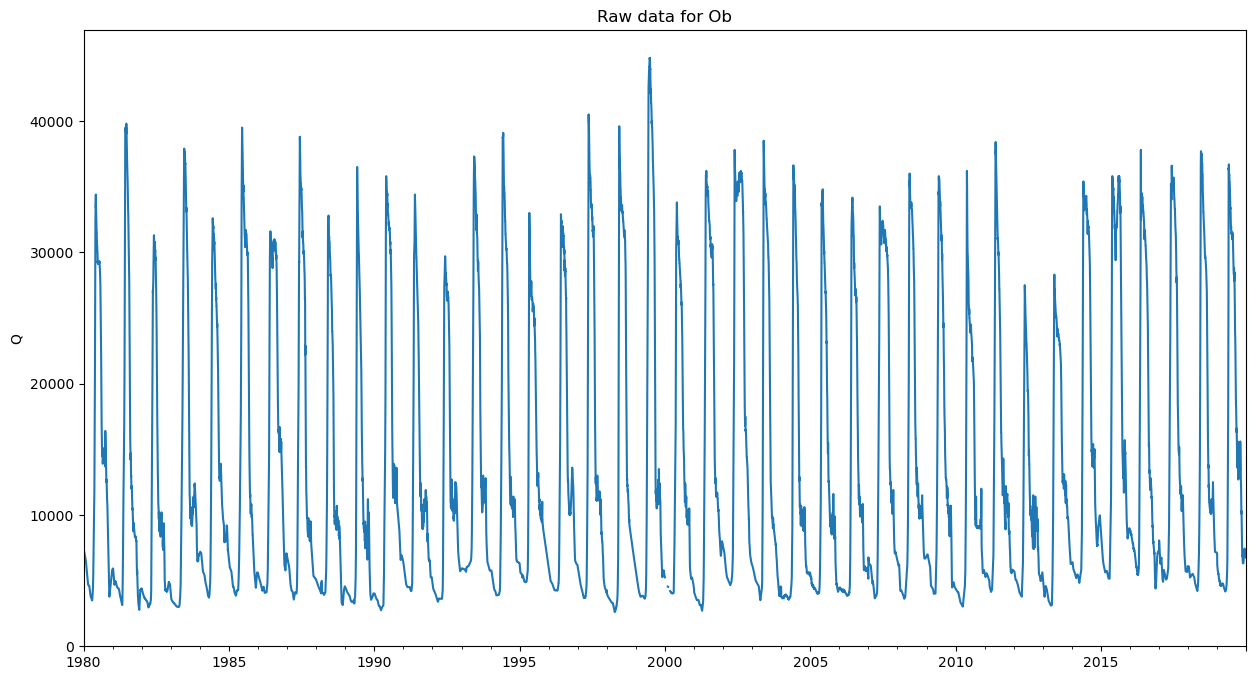

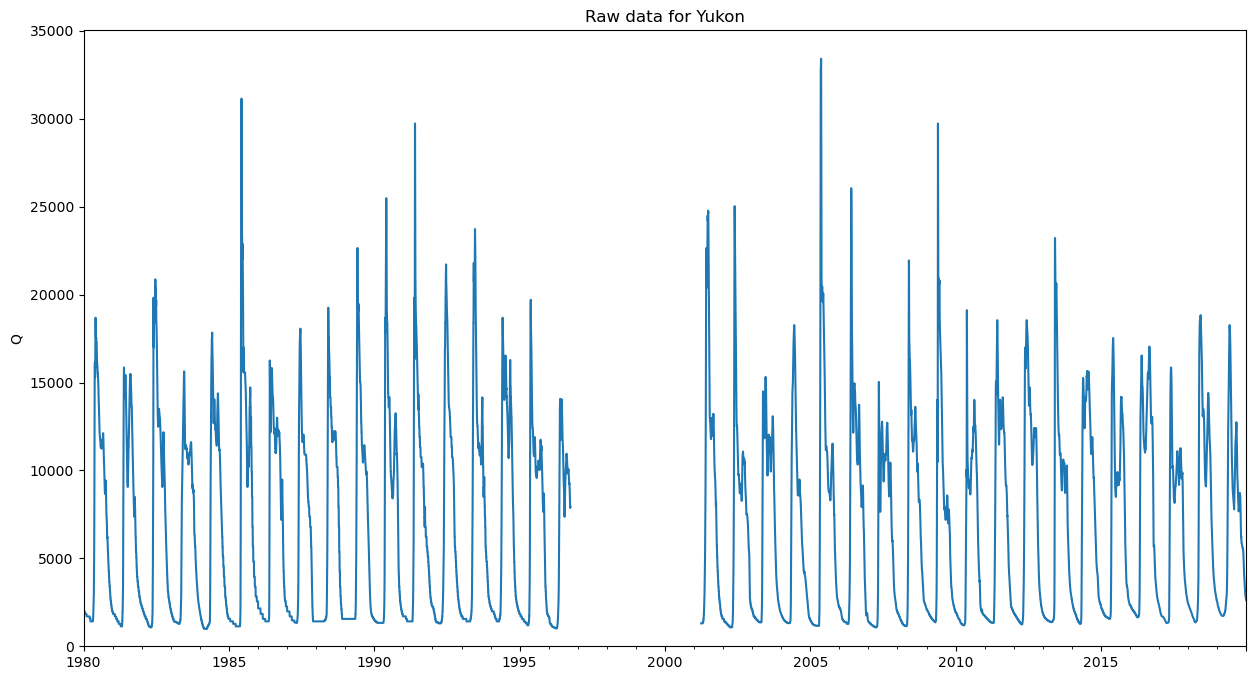

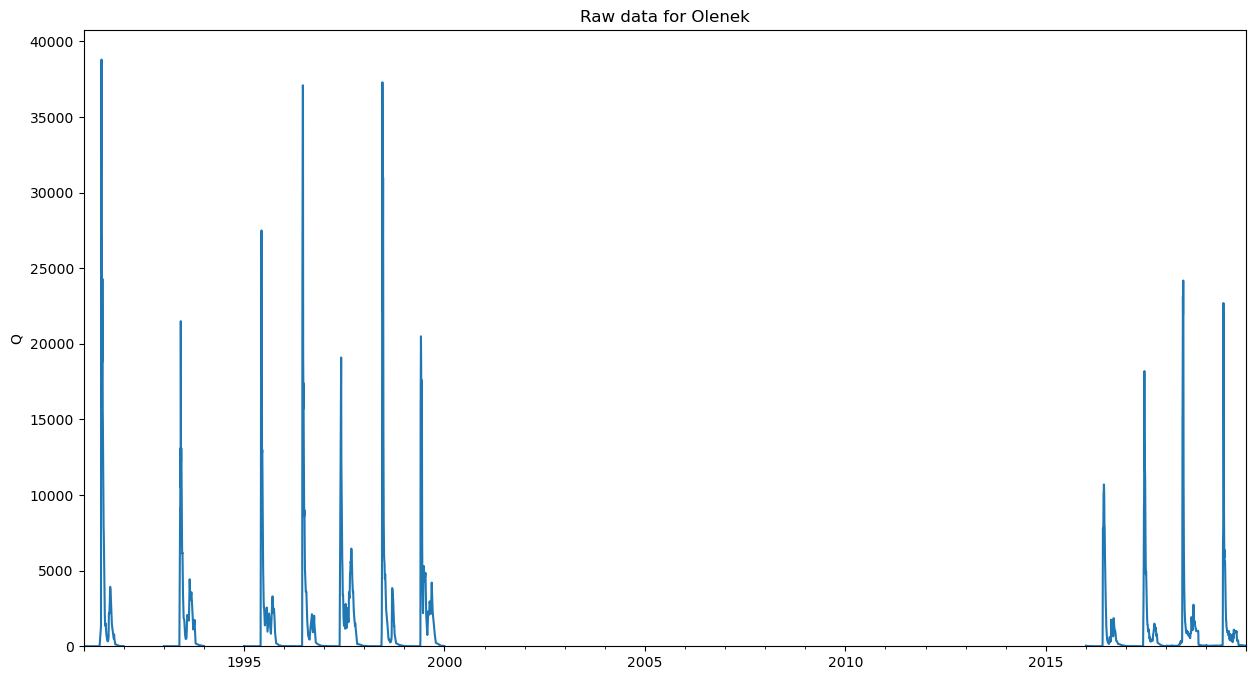

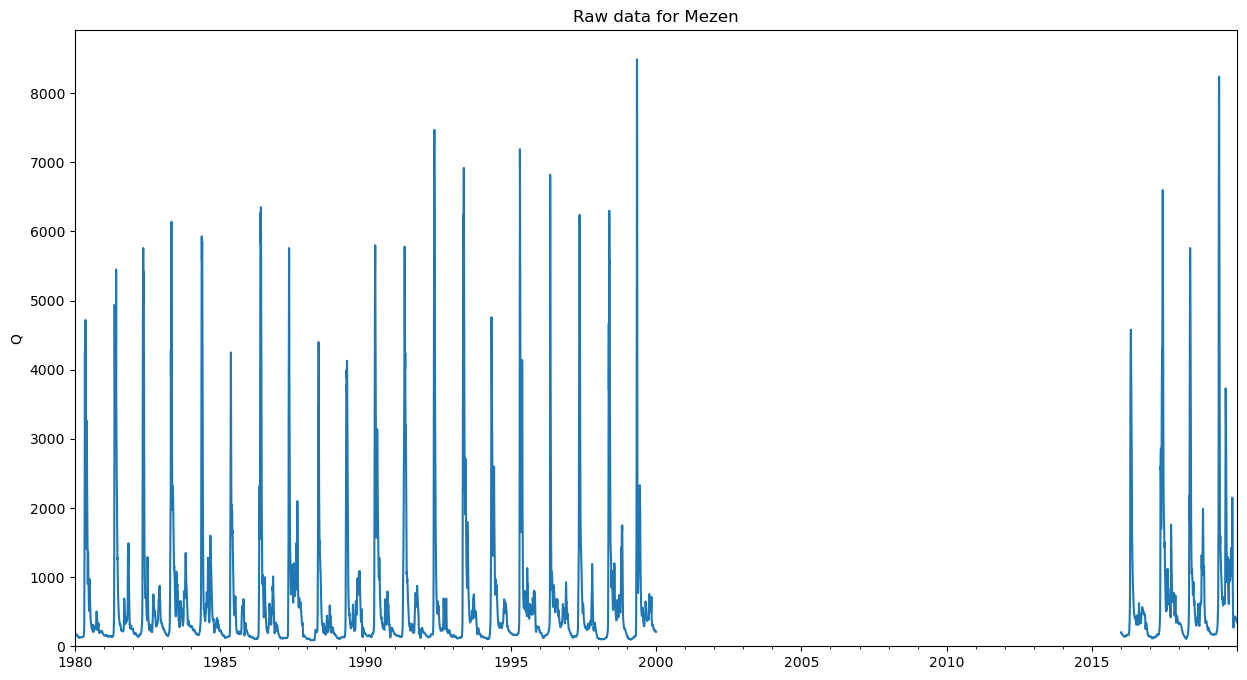

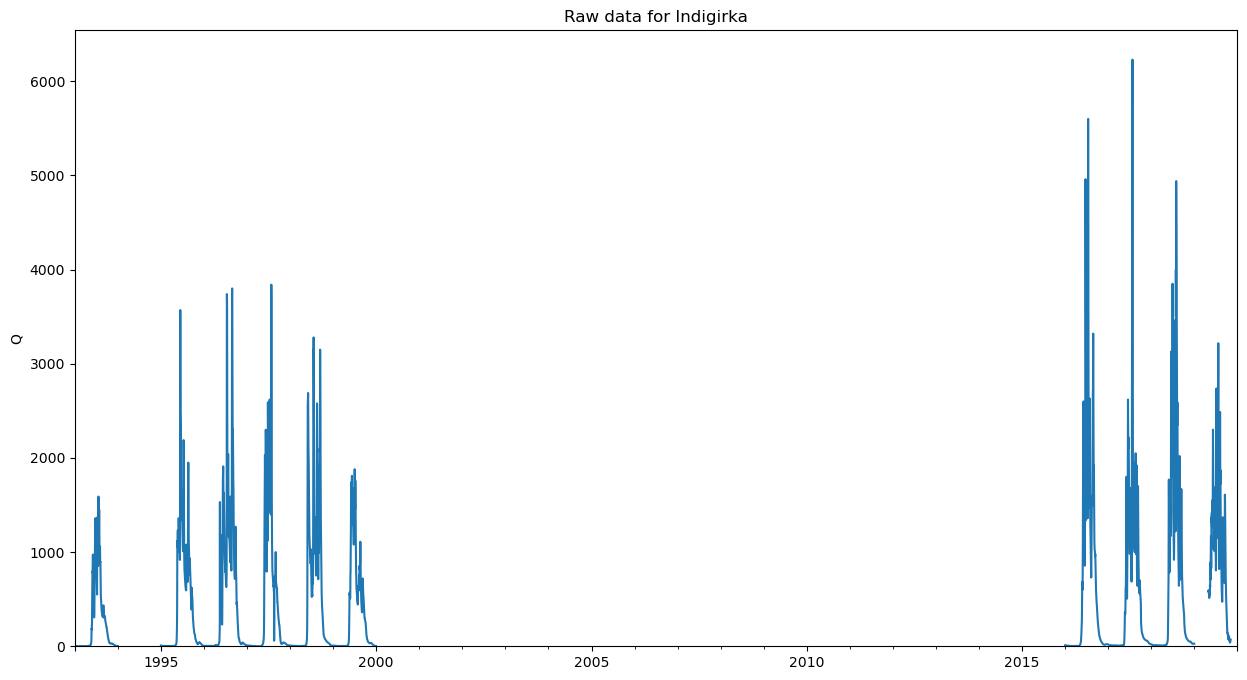

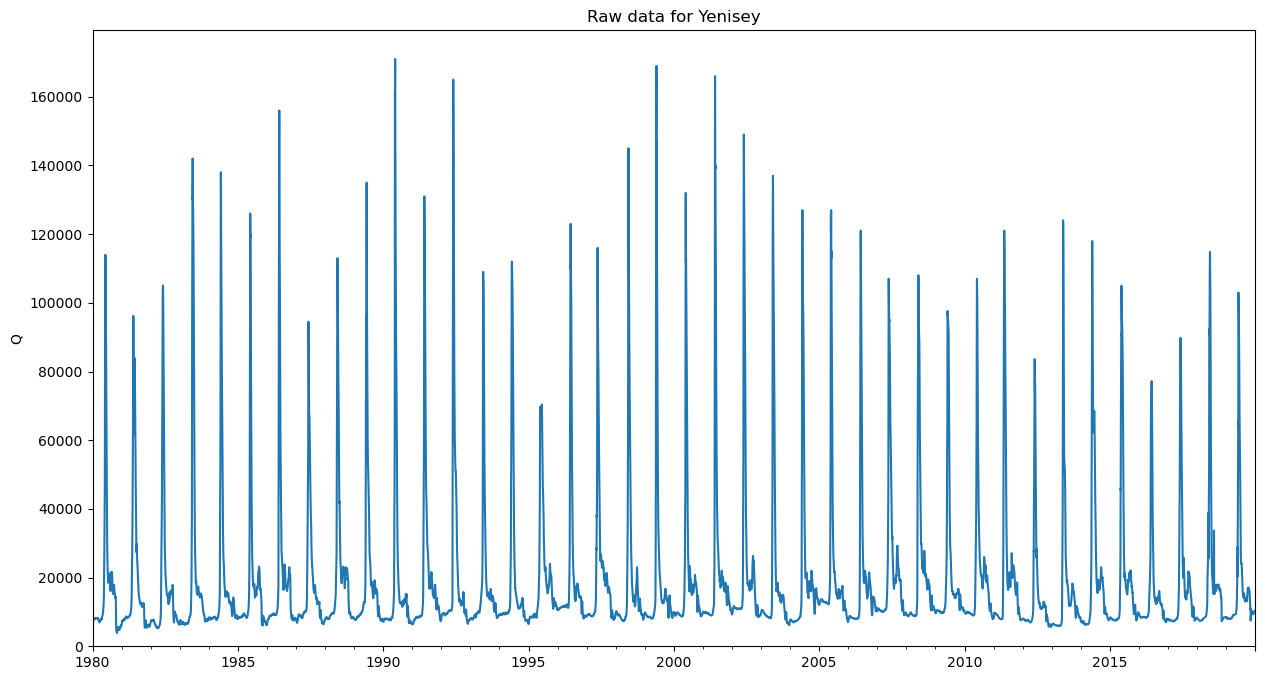

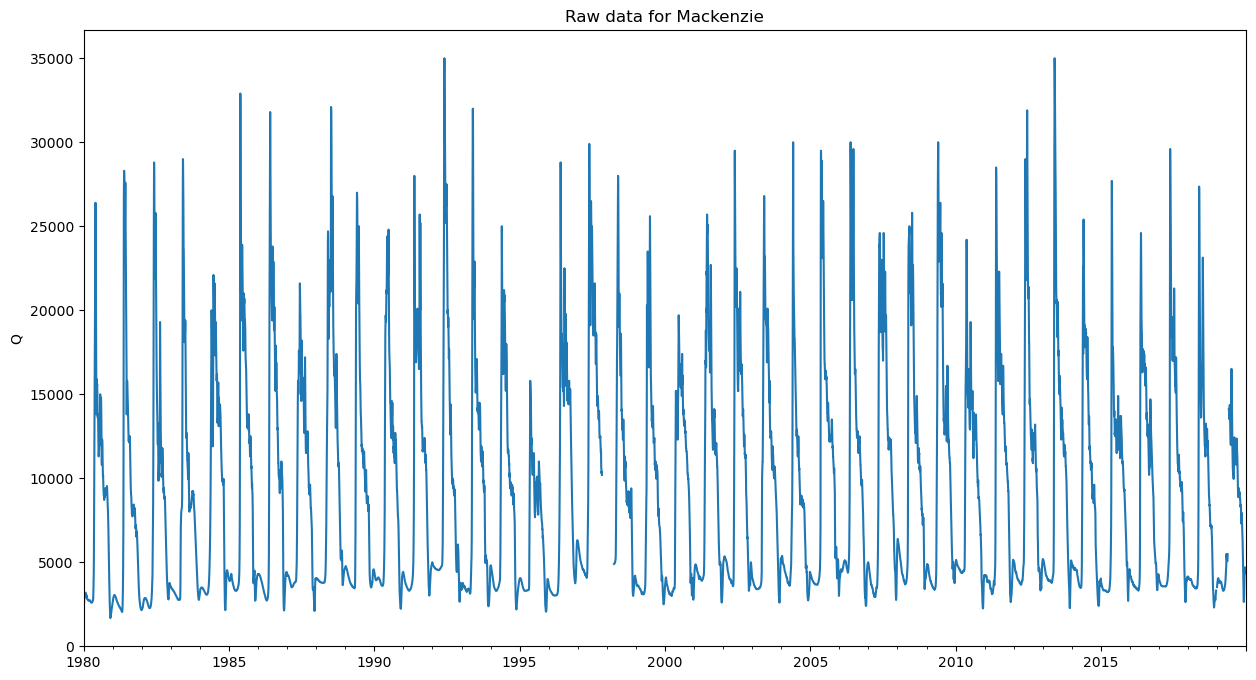

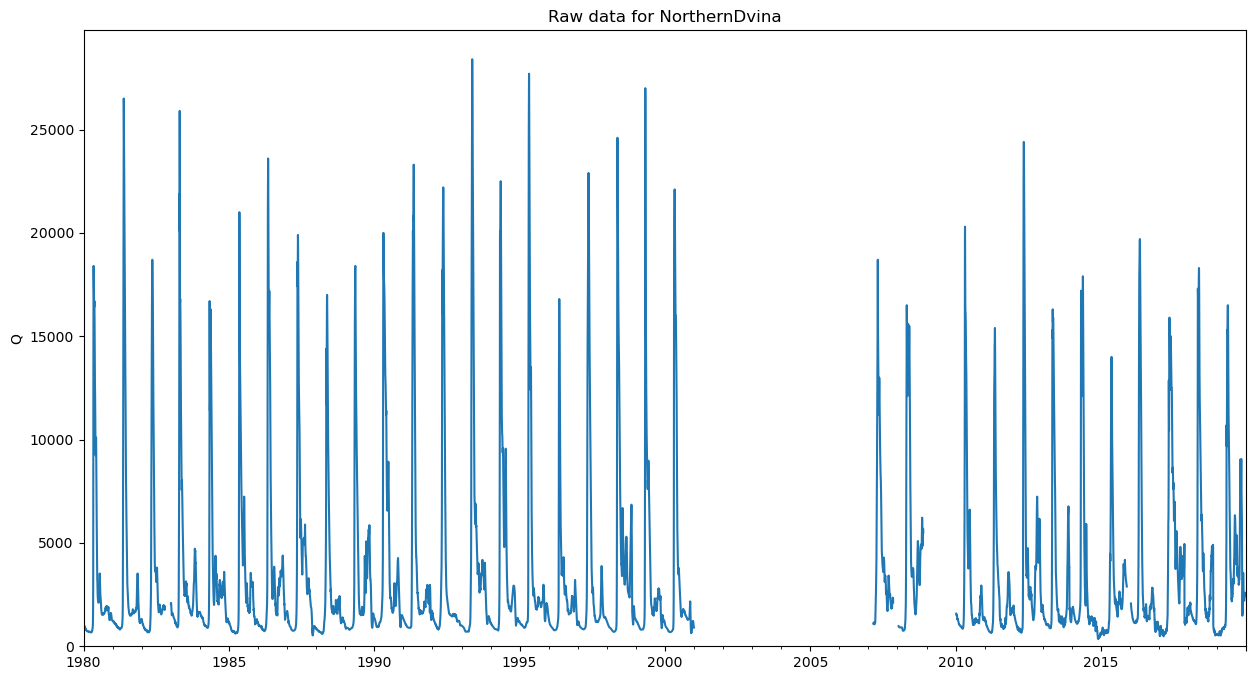

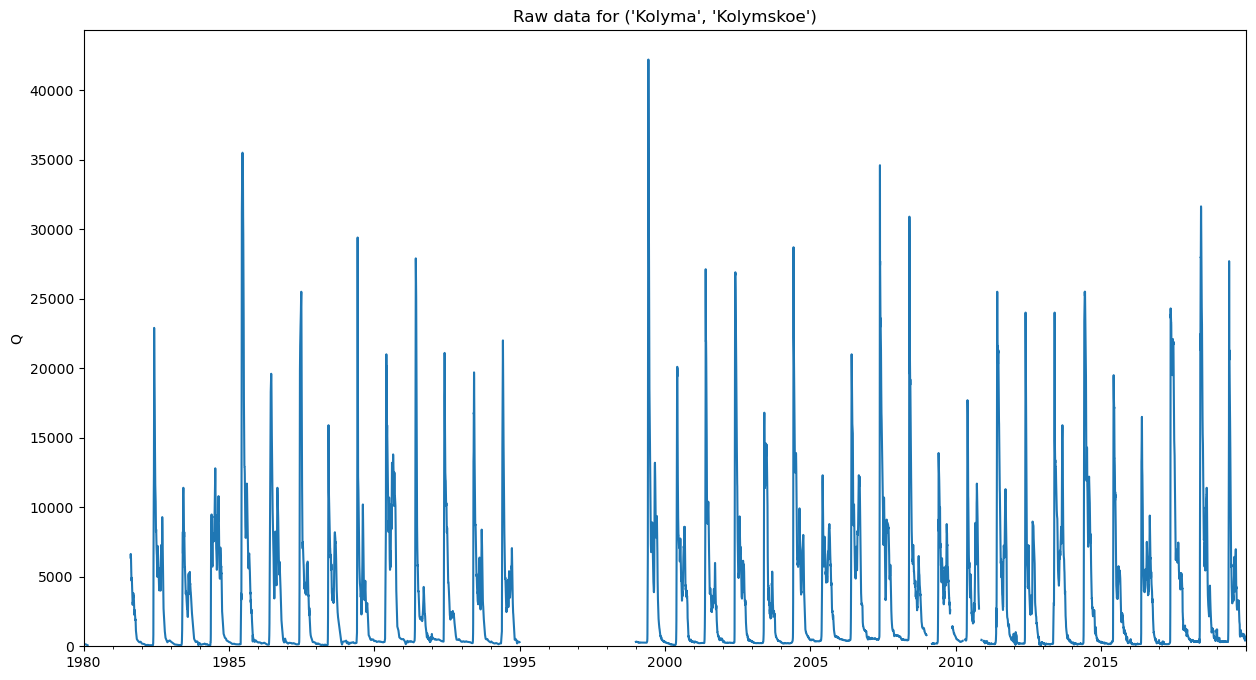

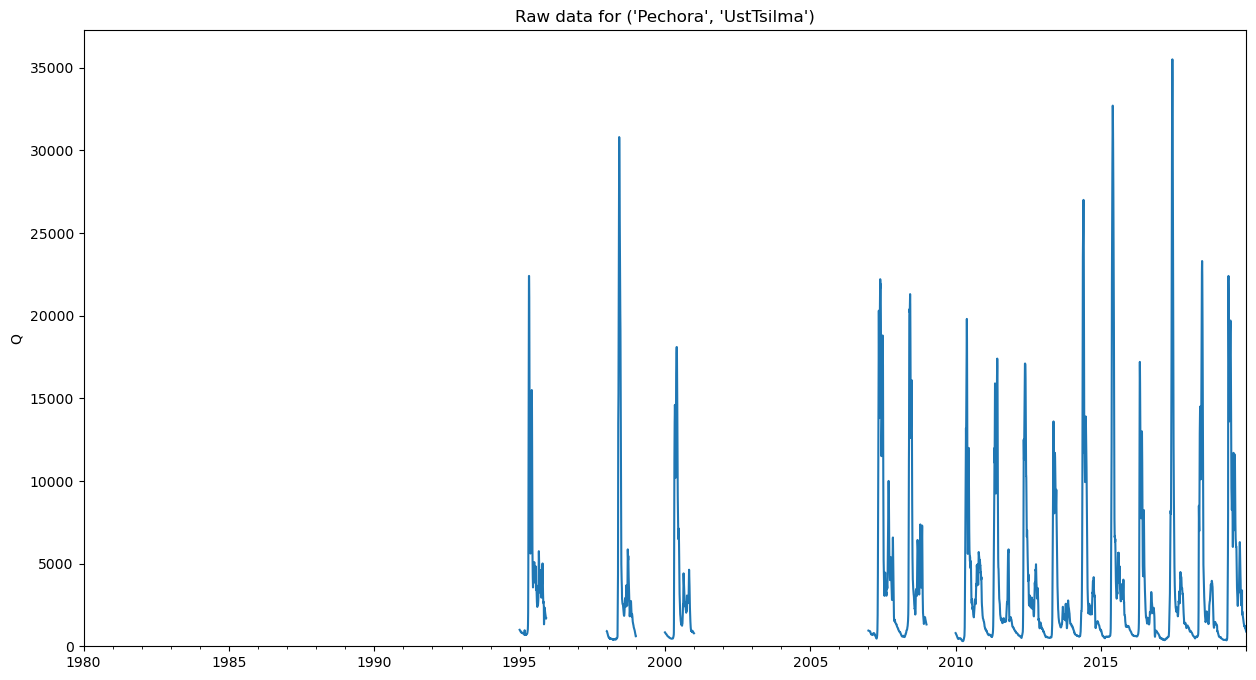

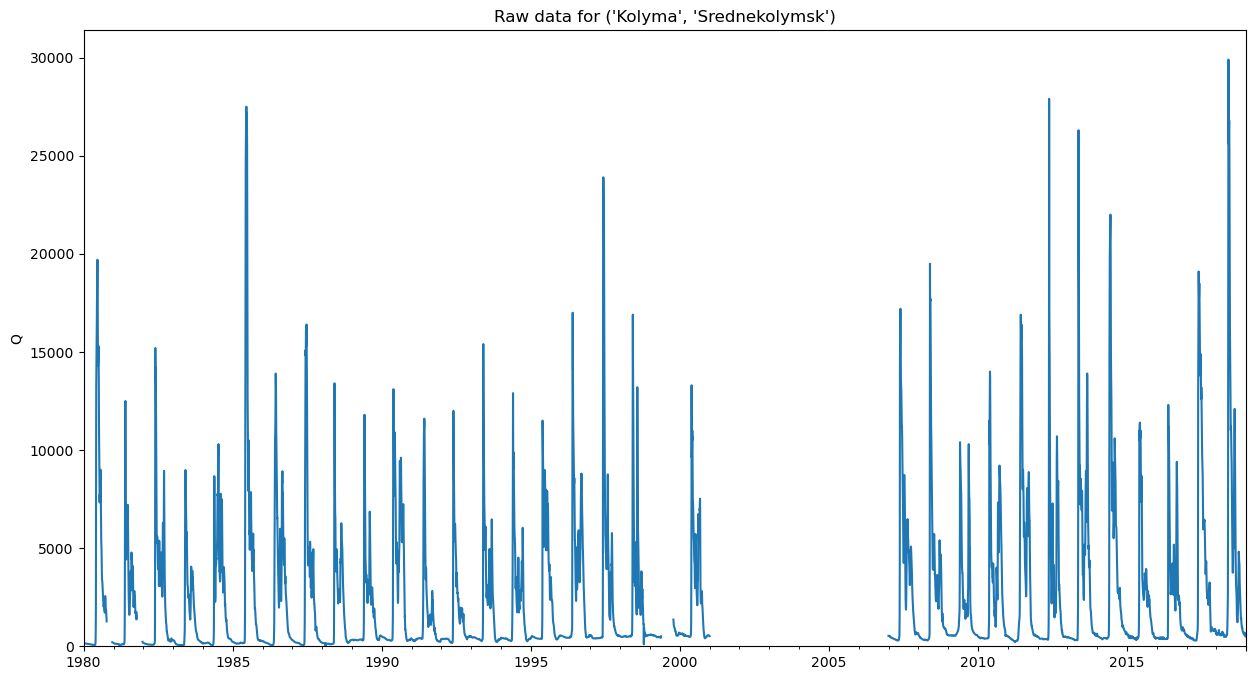

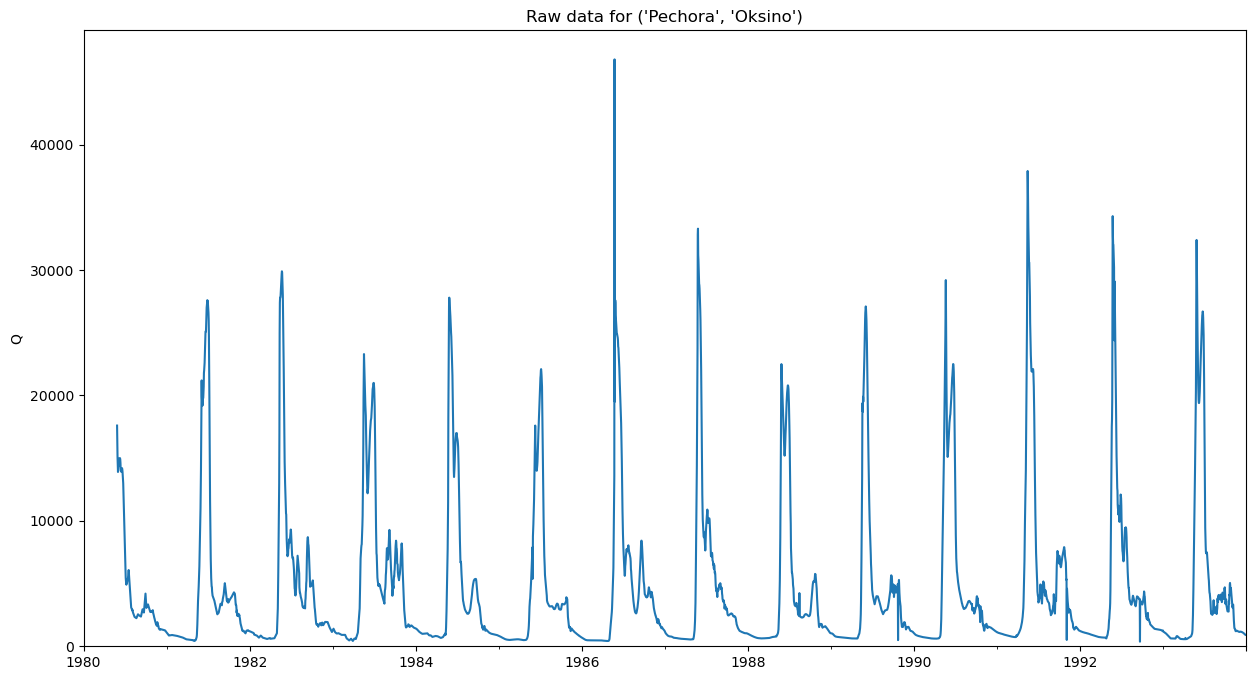

In [4]:
# Quick plot of Q data from each site
for site in list(q_dict.keys()) + list(q_site_dict.keys()):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot()
    if site in q_dict.keys():
        q_dict[site].plot(legend=False, ax=ax)
    else:
        q_site_dict[site].plot(legend=False, ax=ax)
    plt.ylim(ymin=0)
    plt.xlabel("")
    plt.ylabel("Q")
    plt.title("Raw data for %s" % str(site))
    plt.savefig(os.path.join(q_graph_folder,
                             'raw_data_%s-%s_%s' % (st_yr, end_yr, str(site))))

# QC issues: data cleaning
From a quick look, there's some clear data dodginess:
- Onega: Lots of artificial peaks and troughs before 1995. Clear errors when you zoom in. Have been through these in detail, and come up with a list that needs deleting.
- Mackenzie: artificial-looking drop and then rise in Q at the start of every winter, presumably as the river freezes. Should the rise happen, or is that just an artefact? Suspect the latter, as it's not seen in any of the other (presumably not that dissimilar?) rivers.
- Pechora (Oksino): dodgy drops at start of freezing from 1989

For now, decide to delete the dodgy Onega data, but leave Mackenzie and Pechora.


In [5]:
onega_del_dates = [
                   # '1979-06-09',
                   '1980-07-10',
                   '1980-02-29',
                   '1980-07-17',
                   '1980-10-06',
                   '1980-10-17',
                   '1980-10-25',
                   '1980-11-06',
                   '1980-11-17',
                   '1980-12-17',
                   '1980-12-26',
                   '1981-08-14',
                   '1982-05-09',
                   '1982-06-05',
                   '1983-02-01',
                   '1984-09-21',
                   '1984-10-21',
                   '1984-11-21',
                   '1984-12-21',
                   '1985-04-29',
                   '1985-04-30',
                   '1985-07-04',
                   '1985-08-04',
                   '1985-09-04',
                   '1985-10-04',
                   '1985-11-04',
                   '1985-12-04',
                   '1989-04-07',
                   '1989-05-07',
                   '1989-05-09',
                   '1989-06-07',
                   '1989-07-07',
                   '1989-08-07',
                   '1989-09-07',
                   '1990-10-14',
                   '1990-11-14',
                   '1992-05-25', '1992-05-26', '1992-05-27', '1992-05-28',
                   '1992-05-29', '1992-05-30', '1992-05-31']

<AxesSubplot:xlabel='date'>

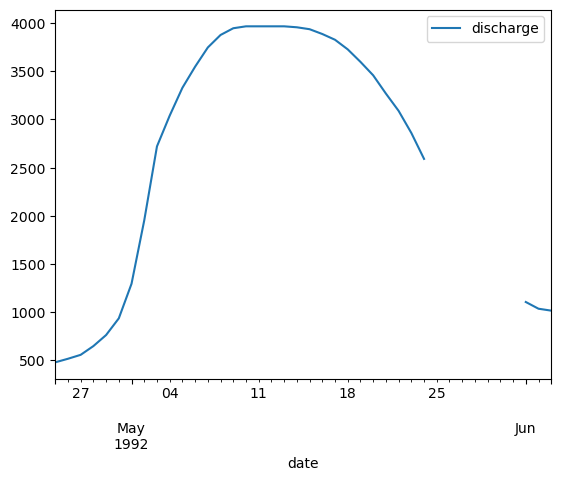

In [6]:
# Delete dodgy data from Onega
q_dict['Onega'].loc[onega_del_dates, 'discharge'] = np.nan

# Quick check
q_dict['Onega']['1992-04-25':'1992-06-03'].plot()

# Merge multiple gauging sites on the same river

In [7]:
def patch_series(series_to_patch, site_names, apply_time_lag,
                 d_between_points, areas=None):
    """
    Function to patch one series using another, using
    a linear regression between the two series if the two series have more than
    365 overlapping days with data. If not, area-scaling is used instead.

    Input:

    series_to_patch: a list of two series. The first should be the one that
    needs patching (y), the second is used to do the patching (x). Also assume
    the first is downstream of the second for now.

    site_names: list of site names associated with the two series
    apply_time_lag: boolean (True or False). Apply a time shift to the second
    series, to account for water travel time between the two sampling points?
    Assumes that the second series is upstream and water velocity of 0.8 m/s
    d_between_points: downstream distance between sampling points (km)

    apply_time_lag: boolean (True or False). If True, apply a time lag to the
    second series, to compensate for the travel time between the two points.
    Assume a constant water velocity of 0.8 m/s (3 km/hr).

    d_between_points: float, the distance between the two monitoring points (km).
    Needed if apply_time_lag is True.

    areas: list with catchment areas associated with two series (km2). Only
    used if area scaling is used for patching instead of regression.
    """
    if apply_time_lag is True:
        # Expect discharge at downstream point (first series) to correspond to Q
        # at upstream point (second series) a few days previously. So shift second
        # series forward in time to match first series.
        day_lag = math.ceil(d_between_points * 1000 / (0.8 * 86400))  # 0.8 m/s, 3 km/hr
        print('day lag applied, series 2 shifted %s days forward' % day_lag)
        shifted_s = series_to_patch[1].shift(periods=day_lag)
        series_to_patch = [series_to_patch[0], shifted_s]

    joined_df = series_to_patch[0].join(series_to_patch[1],
                                        how='outer',
                                        lsuffix='_%s' % site_names[0],
                                        rsuffix='_%s' % site_names[1])

    # Plot of raw series
    joined_df.plot(figsize=(15, 7), title="Plot of raw series")
    plt.ylim(ymin=0);
    plt.show()

    # # Close up plot to check that temporal adjustment looks ok
    # joined_df.loc['1-11-2015':'31-10-2018'].plot(figsize=(18, 8),
    #                                              title="Plot of zoomed raw series")
    # plt.ylim(ymin=0);
    # plt.show()

    # Get ready to patch
    joined_df_no_nans = joined_df.dropna(axis=0)

    days_to_patch = np.array(joined_df[joined_df.iloc[:, 0].isnull()].index)
    x_new = joined_df.iloc[:, 1].loc[days_to_patch].dropna()
    days_to_patch = x_new.index  # Reset days_to_patch, excluding na values

    # Linear regression, if have at least a year of data overlap
    if len(joined_df_no_nans > 365):

        y = joined_df_no_nans.iloc[:, 0].values
        x = joined_df_no_nans.iloc[:, 1].values.reshape((-1, 1))

        model = LinearRegression().fit(x,y)
        y_pred = model.predict(x)

        r_sq = model.score(x,y)
        print('coefficient of determination:', r_sq)
        print('intercept:', model.intercept_)
        print('slope:', model.coef_)

        # Plot output of linear regression
        plt.scatter(x, y, color="black")
        plt.plot(x, y_pred, color="blue", linewidth=2)
        plt.xlabel(site_names[0])
        plt.ylabel(site_names[1])
        plt.show()

        # Predict values for gaps in the first series, using observations from the second series
        x_new = x_new.values.reshape((-1, 1))
        y_new = model.predict(x_new)
        s0_to_patch = pd.Series(index=days_to_patch, data=y_new)

    # If not enough overlapping data for a regression, apply area-scaling
    else:
        s0_to_patch = series_to_patch[1].dropna() * (areas[0]/areas[1])
        s0_to_patch = s0_to_patch.squeeze()  # Convert from df to series

    s0_to_patch.name = 'discharge'
    patched_series = joined_df.iloc[:, 0].combine_first(s0_to_patch)
    joined_df['patched'] = patched_series

    # Plot to check that patching has worked ok and looks sensible
    print('Number of days patched in the first series (x): %s' % len(days_to_patch))

    axs = joined_df.plot(figsize=(18, 8), subplots=True, sharex=True)
    for ax in axs:
        plt.ylim(ymin=0);
    plt.title("Raw and patched series")
    plt.show()

    return patched_series

day lag applied, series 2 shifted 5 days forward


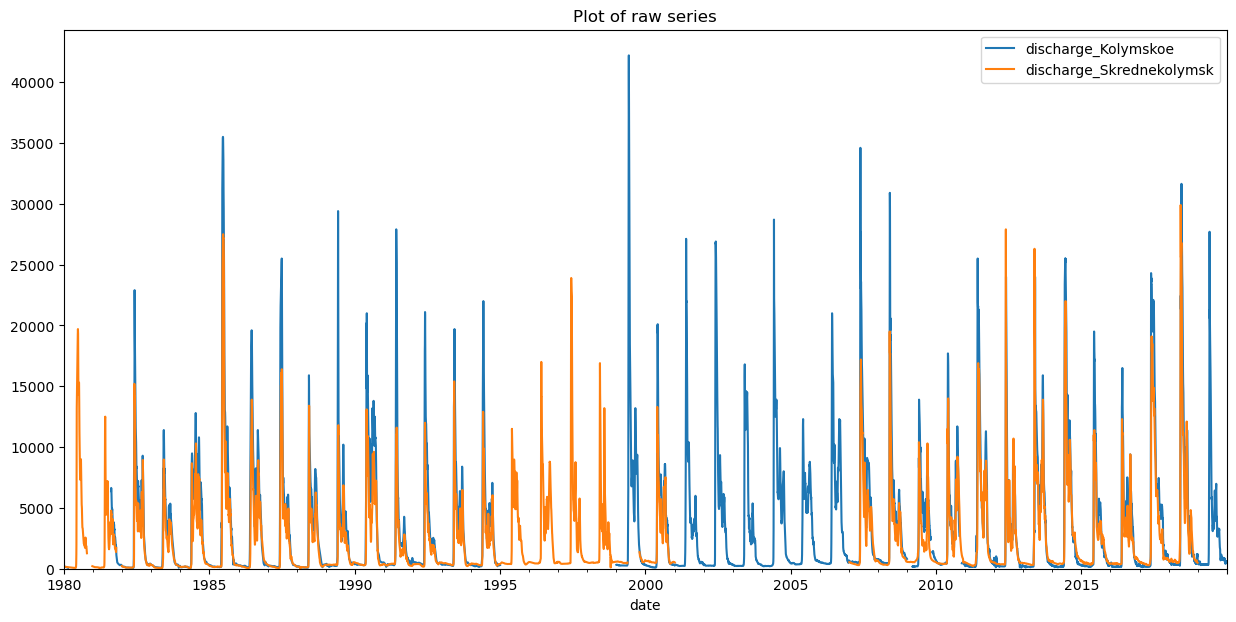

coefficient of determination: 0.8892823921456424
intercept: 92.89381780431722
slope: [1.29790053]


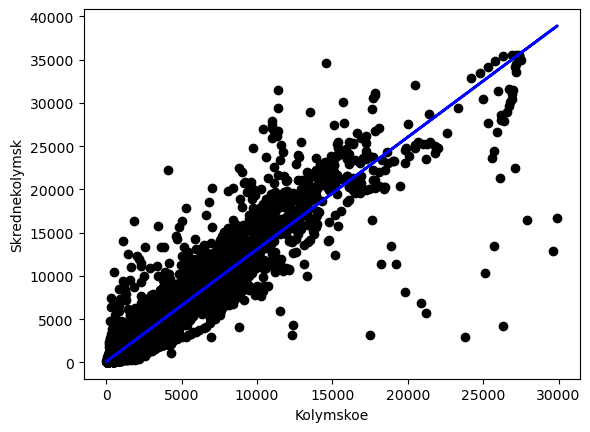

Number of days patched in the first series (x): 2129


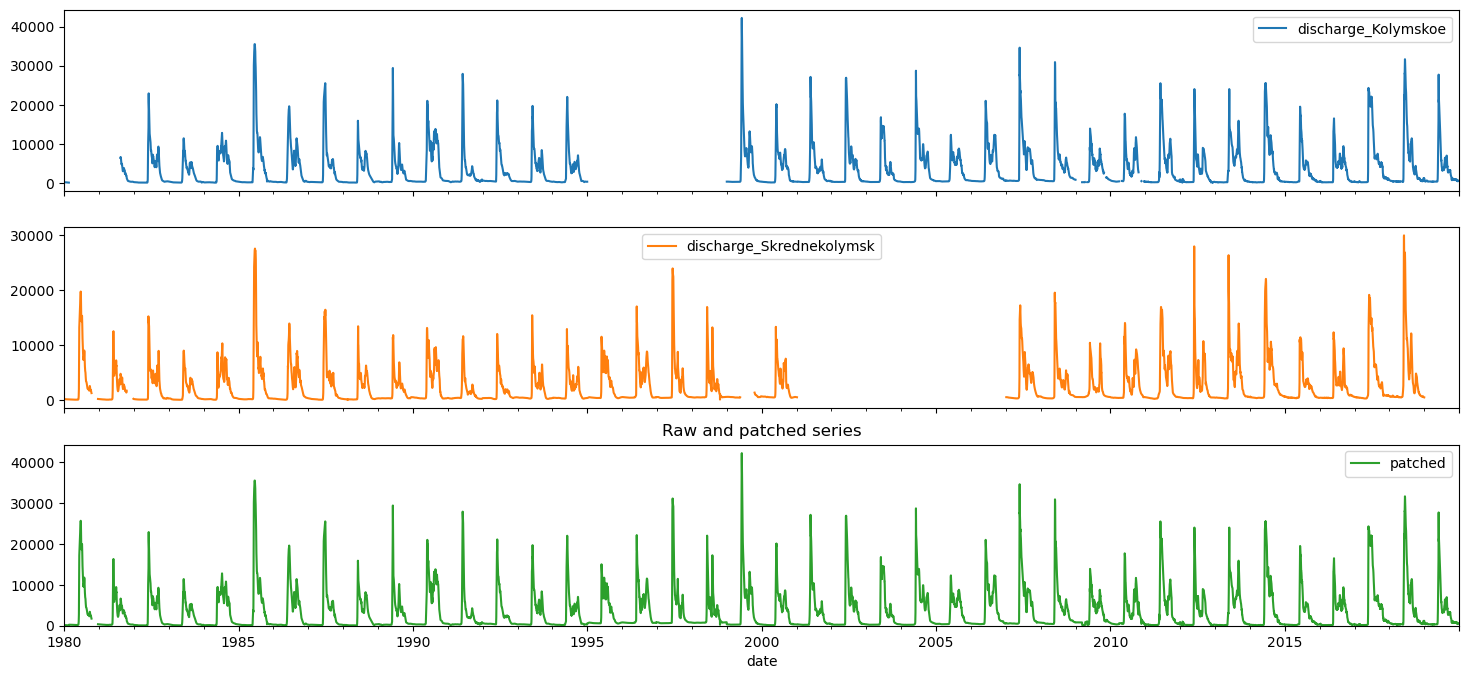

In [8]:
# Patch the two stations on the Kolyma river to make one series at Kolymskoe
s_to_join = [q_site_dict[('Kolyma', 'Kolymskoe')],
             q_site_dict[('Kolyma', 'Srednekolymsk')]]
s_names = ['Kolymskoe', 'Skrednekolymsk']
apply_time_lag = True
d_between_points = 320  # km

# To do: reset name of Q before adding to dict, so it's just 'discharge', not 'discharge_Kolymskoe'
q_dict['Kolyma'] = patch_series(s_to_join, s_names, apply_time_lag, d_between_points).to_frame()

day lag applied, series 2 shifted 6 days forward


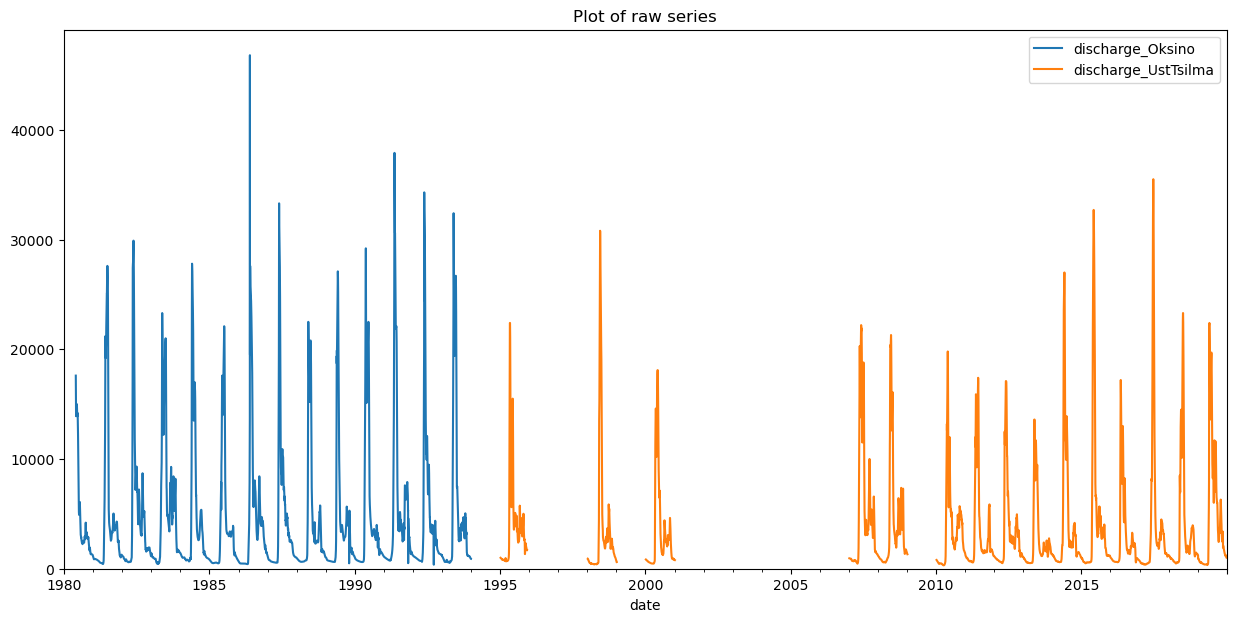

Number of days patched in the first series (x): 5442


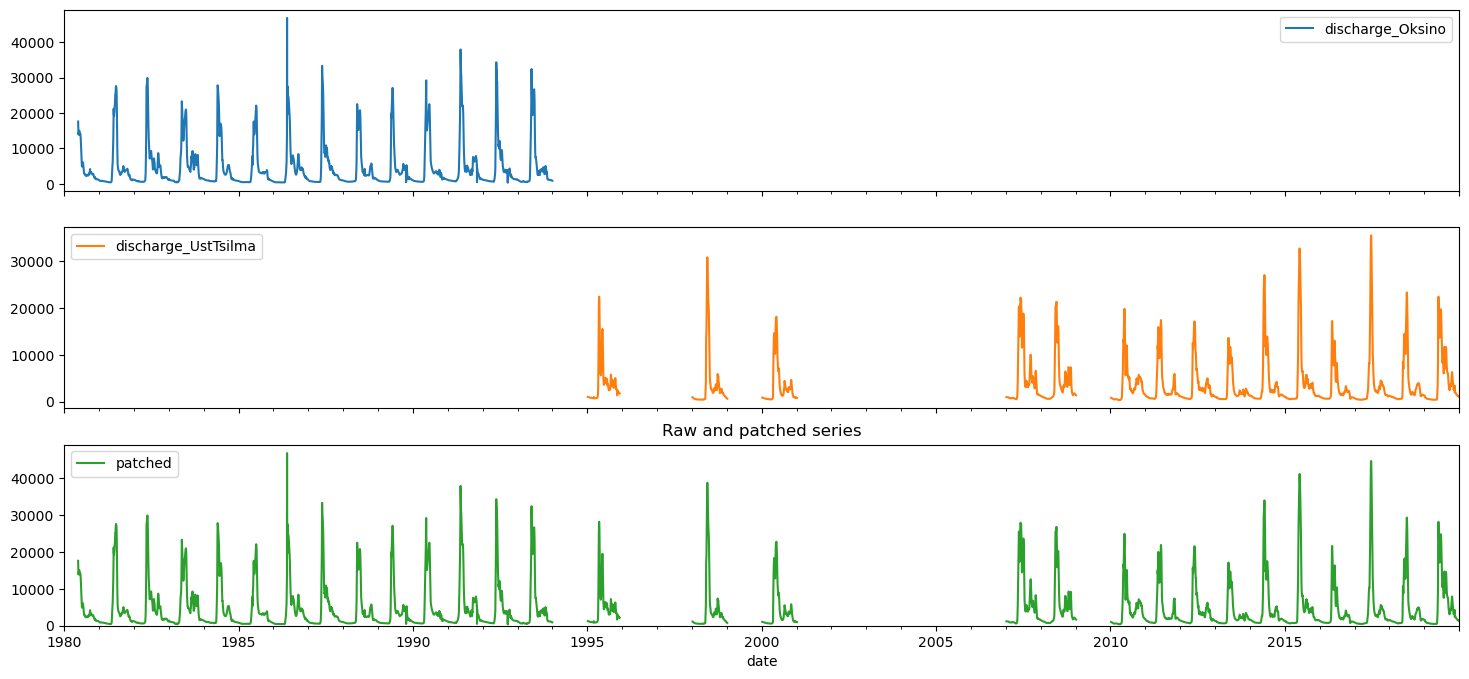

In [9]:
# Pechora river. Oksino is the downstream station, but has much less monitoring
# data than Ust-Tsilma. No overlapping data, so area-scale.
# Decide to area-scale Ust-Tsilma to get patched series for Oksino.

series_to_patch = [q_site_dict[('Pechora', 'Oksino')], q_site_dict[('Pechora', 'UstTsilma')]]
site_names = ['Oksino', 'UstTsilma']
apply_time_lag = True
d_between_points = 388  # km, according to https://www.compositerunoff.sr.unh.edu/html/Polygons/P6970650.html
areas = [312000, 248000]  # Oksino, Ust-Tsilma; km2

q_dict['Pechora'] = patch_series(series_to_patch, site_names, apply_time_lag, d_between_points, areas).to_frame()

# Interpolate to fill short gaps

After a bit of playing around, a gap size of under 75 seems appropriate. i.e. only interpolate when the gap size is less than 75 days. Implementing this is a little bit fiddly, hence the mask in the code below.

In [10]:
nan_limit = 75
q_interp_dict = {}  # Key: river name, returns dict of Q with short gaps filled

for river in q_dict.keys():
    data = q_dict[river]
    mask = data.copy()
    grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
    grp['ones'] = 1
    for i in data.columns:
        mask[i] = (grp.groupby(i)['ones'].transform('count') < nan_limit) | data[i].notnull()
    filled_series = data.interpolate(method='linear')[mask]
    q_interp_dict[river] = filled_series

    # Print out number of NaNs filled per river
    NaNs_start = int(q_dict[river].isna().sum())
    NaNs_end = int(filled_series.isna().sum())
    NaNs_filled = NaNs_start - NaNs_end
    print("%s: %s NaNs filled by interpolation, %s remaining" % (river, NaNs_filled, NaNs_end))

Onega: 42 NaNs filled by interpolation, 8195 remaining
Pur: 61 NaNs filled by interpolation, 386 remaining
Yana: 1 NaNs filled by interpolation, 7227 remaining
Lena: 0 NaNs filled by interpolation, 0 remaining
Nadym: 57 NaNs filled by interpolation, 10577 remaining
Ob: 60 NaNs filled by interpolation, 0 remaining
Yukon: 0 NaNs filled by interpolation, 1643 remaining
Olenek: 0 NaNs filled by interpolation, 6575 remaining
Mezen: 0 NaNs filled by interpolation, 5844 remaining
Indigirka: 56 NaNs filled by interpolation, 6327 remaining
Yenisey: 0 NaNs filled by interpolation, 0 remaining
Mackenzie: 23 NaNs filled by interpolation, 151 remaining
NorthernDvina: 192 NaNs filled by interpolation, 2668 remaining
Kolyma: 67 NaNs filled by interpolation, 0 remaining
Pechora: 0 NaNs filled by interpolation, 4201 remaining


**Result**: Of the big 6, only the Mackenzie and the Yukon still have NaNs (a small'ish half year gap in the Mackenzie, and about 4.5 year gap in the Yukon). Good!

<AxesSubplot:xlabel='date'>

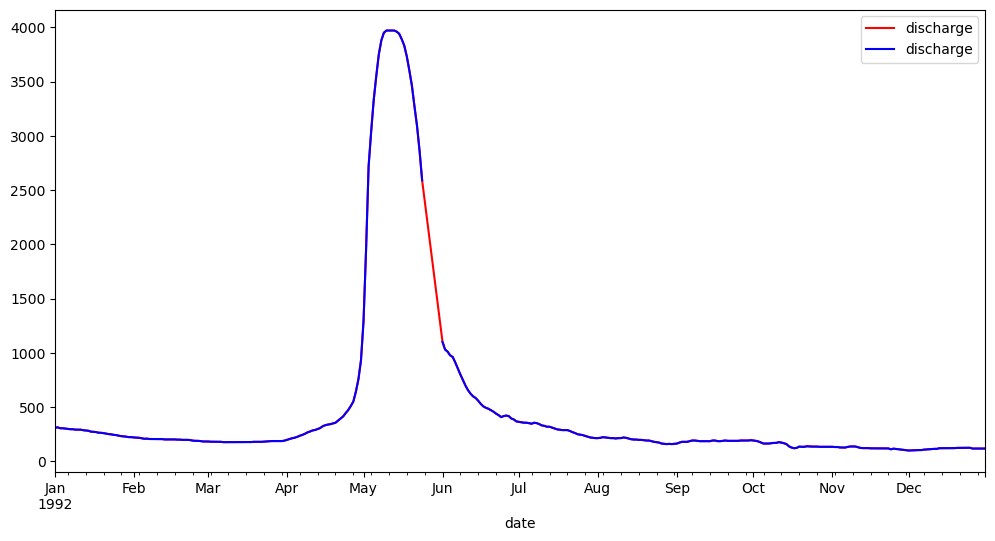

In [11]:
# Plot an example to check working ok
riv = 'Onega'
st = '1992'
end = '1992'
ax = plt.figure().add_subplot(111)
q_interp_dict[riv].loc[st:end].plot(color='r', figsize=(12,6), ax=ax)
q_dict[riv].loc[st:end].plot(color='b', ax=ax)

## Special treatment for Mackenzie

Of the big 6, there are still some NaNs in Mackenzie and Yukon. Leave the big gap in the Yukon for now (could consider patching with RADR for CQ relationships, to come back to...), but what about the Mackenzie?

<AxesSubplot:xlabel='date'>

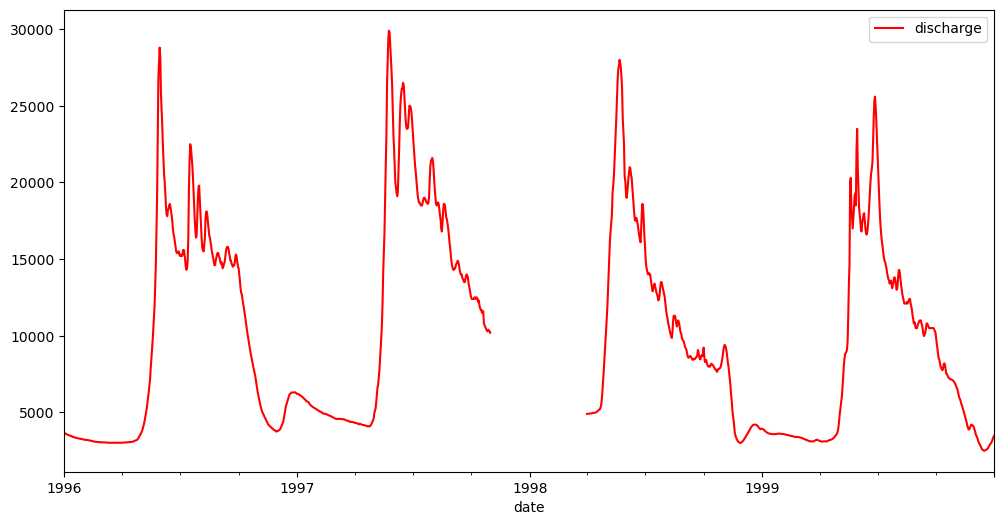

In [12]:
riv = 'Mackenzie'
st = '1996'
end = '1999'
q_interp_dict[riv].loc[st:end].plot(color='r', figsize=(12,6))

Would be easy to fill this gap in by hand in a reasonable way. Decide to try to reproduce that here in a rough way by:
* Using the mean march discharge from the rest of the record to fill the data from mid-November onwards
* Linearly interpolate the small remaining gap at the start of the period

/tmp/ipykernel_126/4275926932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['1997-11-20':].fillna(value=winter_q, inplace=True)
/tmp/ipykernel_126/4275926932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['1997-09-01':].interpolate(method='linear', inplace=True)


Remaining NaNs: 0


<AxesSubplot:xlabel='date'>

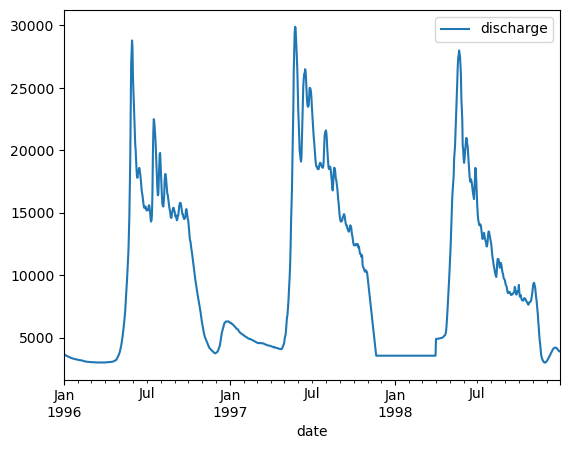

In [13]:
df = q_interp_dict['Mackenzie']

winter_q = df.loc[df.index.month == 3].mean()[0]
df.loc['1997-11-20':].fillna(value=winter_q, inplace=True)
df.loc['1997-09-01':].interpolate(method='linear', inplace=True)

# Remaining NaNs?
print("Remaining NaNs: %s" % int(df.isna().sum()))

q_interp_dict['Mackenzie'].loc['1996-01-01': '1998-12-31'].plot()

The result looks a bit steppy, but otherwise ok. Perhaps even better than the observed data, which shows odd bumps and peaks through winter, which are probably just ice artefacts.

In [14]:
# # Future improvement would be to change the interpolation limit
# # according to the season (much longer if outside the melt season).
# # But not immediately obvious how to do, so leave for now.

# def season(x):
#     """Input month number, and return the season it corresponds to
#     """
#     if x in [9,10,11,12,1,2,3]:
#         return 'winter'
#     else:
#         return 'summer'

# limit_dict = {'winter': 120, 'summer': 30}

# cur_df['season'] = cur_df.index.month.map(season)

# Write cleaned, patched and interpolated daily data to csv

In [15]:
for riv in riv_list:
    q_interp_dict[riv].to_csv(os.path.join(q_cleaned_daily_folder,
                                           '%s_daily_%s-%s.csv' % (riv, st_yr, end_yr)))

# Convert to monthly

In [16]:
q_monthly_dict = {}  # Key: river name, returns monthly mean Q

for riv in riv_list:
    # q_monthly_dict[riv] = q_dict[riv].resample('M').mean(min_count=20)
    daily_df = q_interp_dict[riv]
    monthly_df = daily_df.resample('M').agg(np.mean)
    q_monthly_dict[riv] = monthly_df

<AxesSubplot:xlabel='date'>

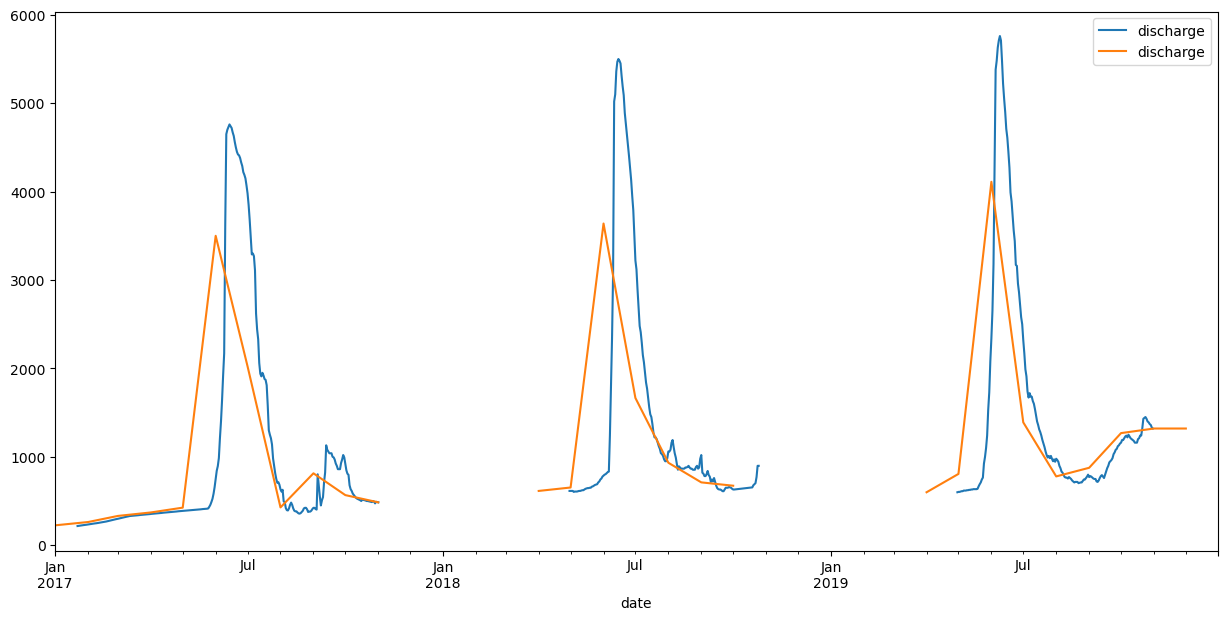

In [17]:
# Quick plot to check working ok
riv = 'Pur'
ax = plt.figure(figsize=(15, 7)).add_subplot(111)
q_dict[riv].plot(ax=ax)
q_monthly_dict[riv].plot(ax=ax)

Looks ok, except the left-closed indexing makes it look a little strange.

## Write monthly data to csv


In [18]:
for riv in riv_list:
    q_monthly_dict[riv].to_csv(os.path.join(q_cleaned_monthly_folder,
                                            '%s_monthly_%s-%s.csv' % (riv, st_yr, end_yr)))

In [19]:
q_monthly_dict['Kolyma'].head()

discharge_Kolymskoe
date                           
1980-01-31           144.032258
1980-02-29           140.652087
1980-03-31           234.331482
1980-04-30           199.879759
1980-05-31           195.775462

## Define ice vs flow seasons

### Monthly plot

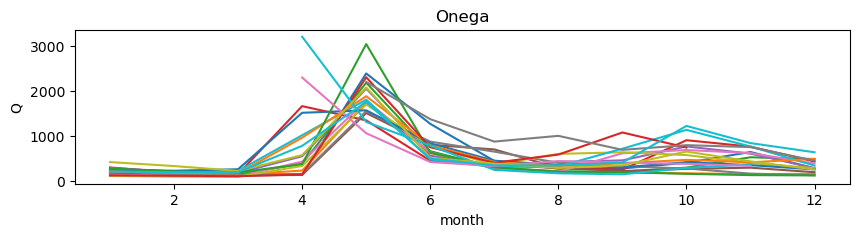

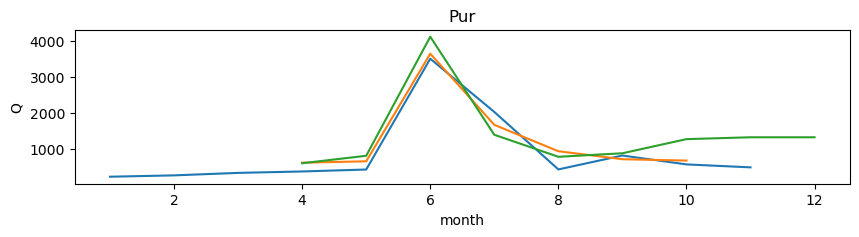

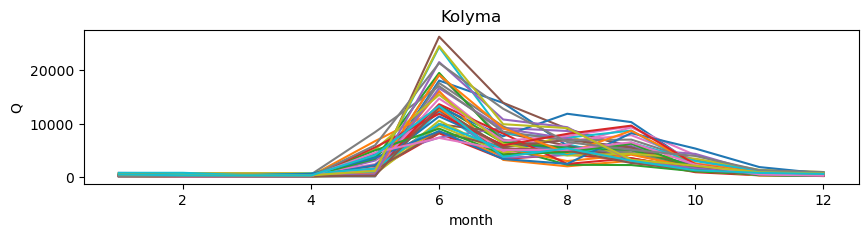

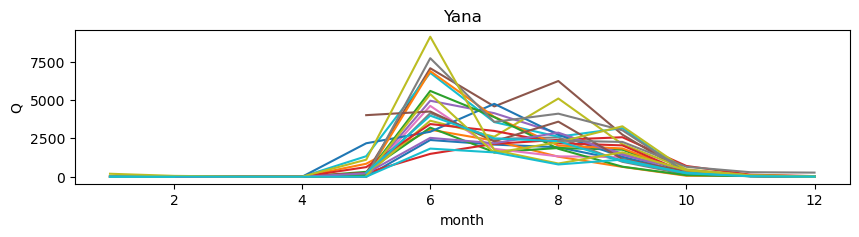

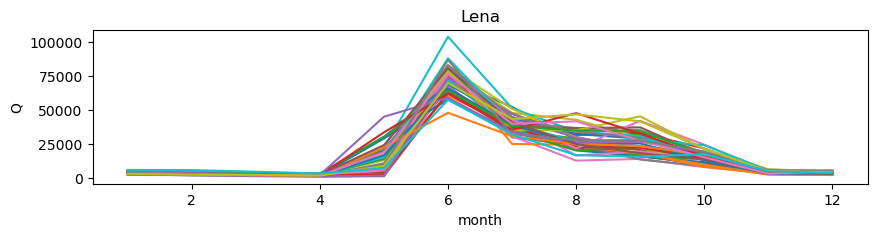

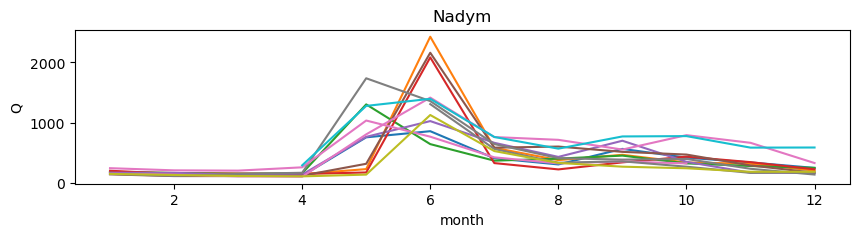

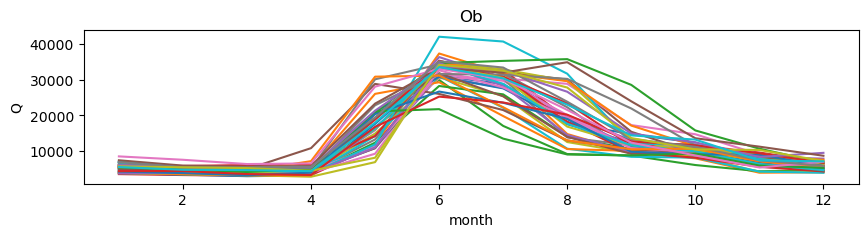

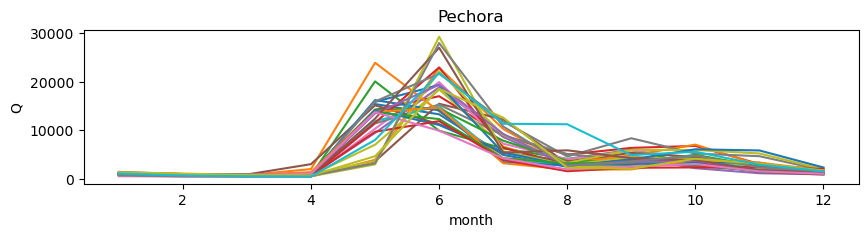

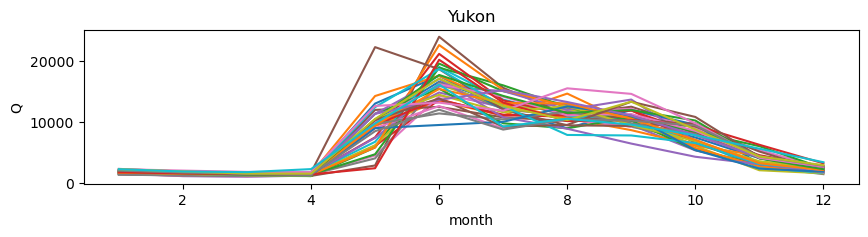

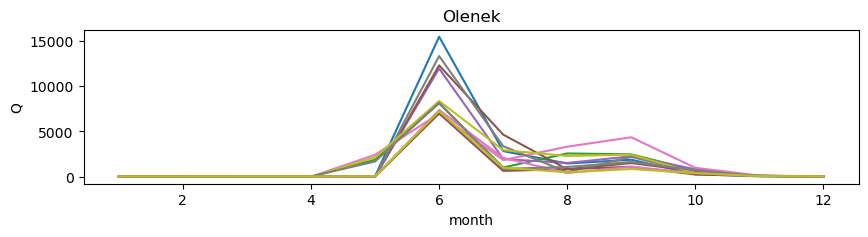

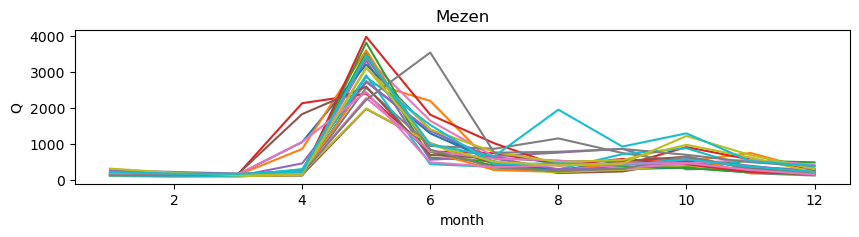

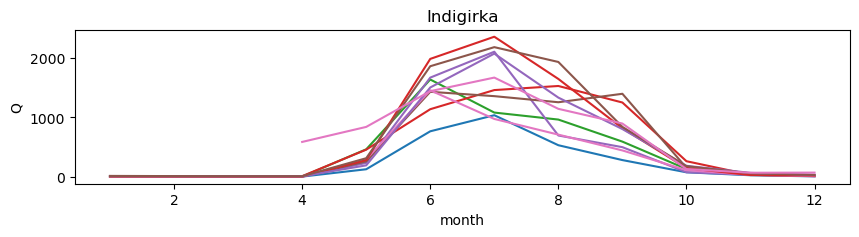

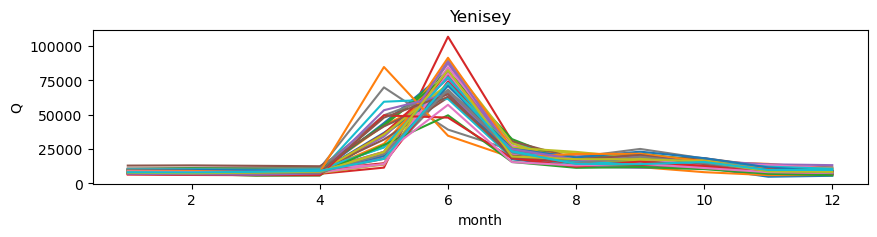

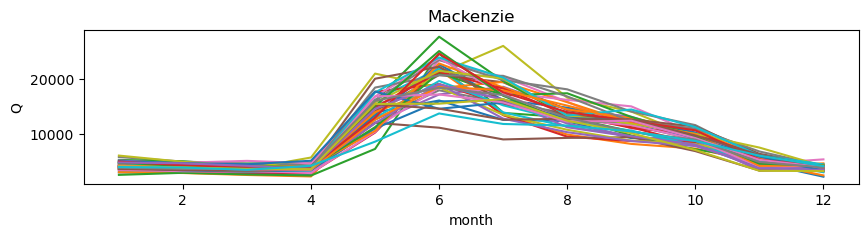

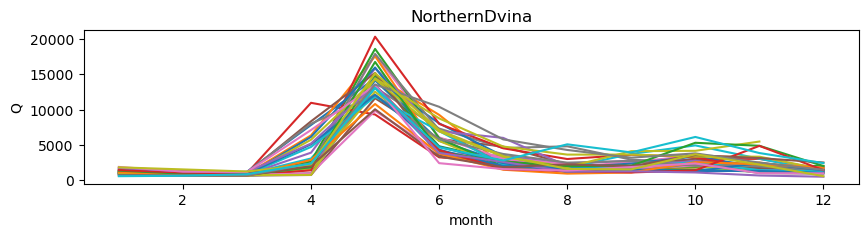

In [20]:
for riv in riv_list:
    df = q_monthly_dict[riv]
    df['year'] = df.index.year

    fig = plt.figure(figsize=(10, 2))
    ax = fig.add_subplot()

    grouped = df.groupby('year')

    for year, yr_df in grouped:
        yr_df.index = yr_df.index.month
        yr_df.iloc[:, 0].plot(ax=ax, legend=False)

    plt.xlabel('month')
    plt.ylabel('Q')
    plt.title(riv)

### Daily plots

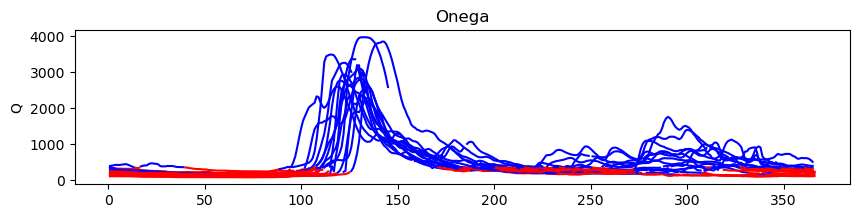

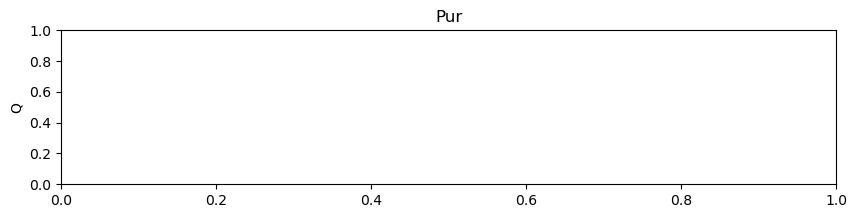

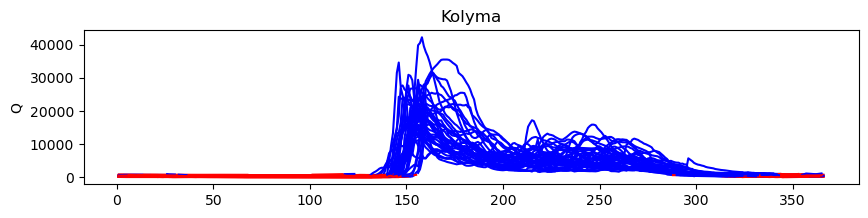

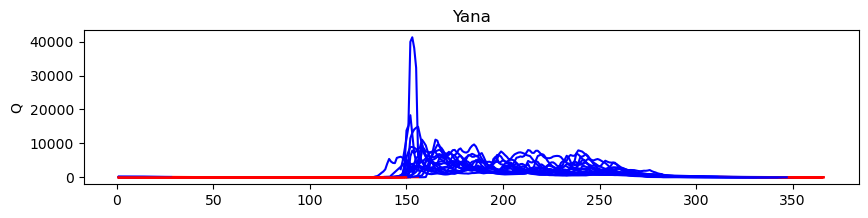

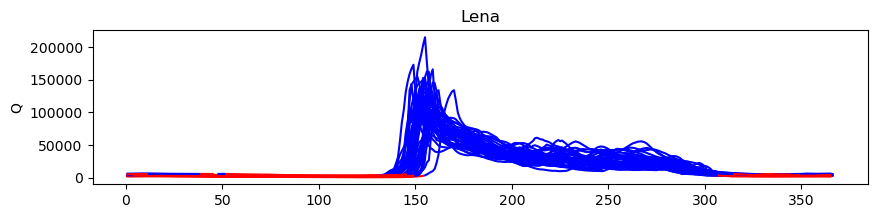

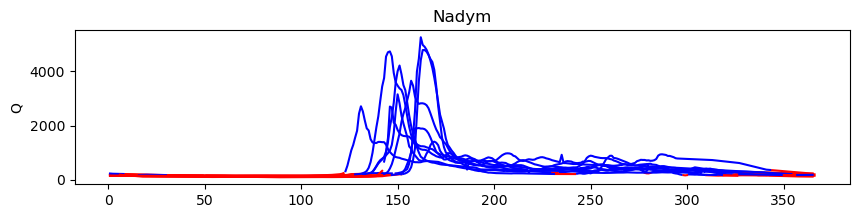

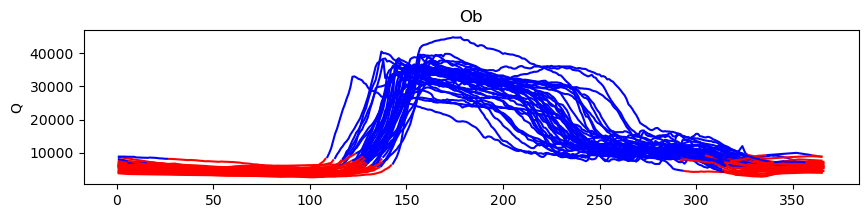

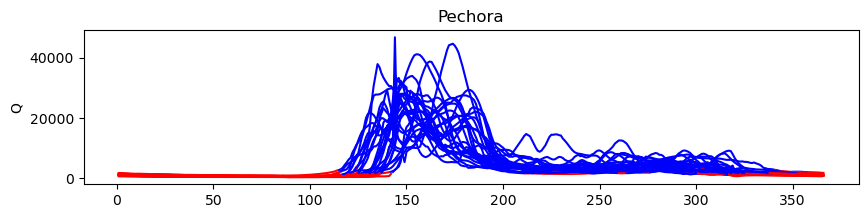

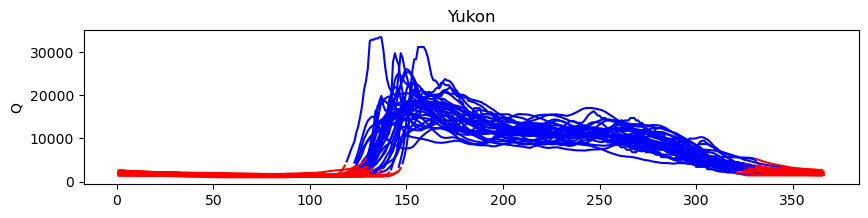

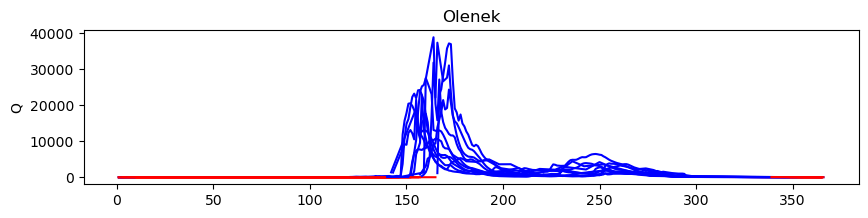

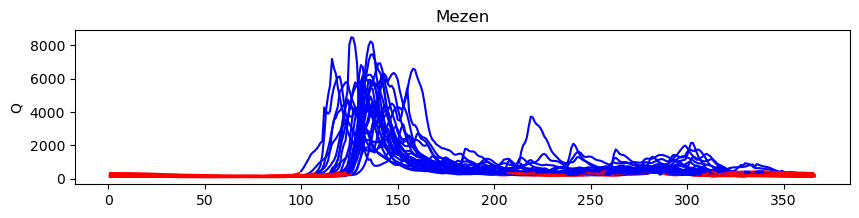

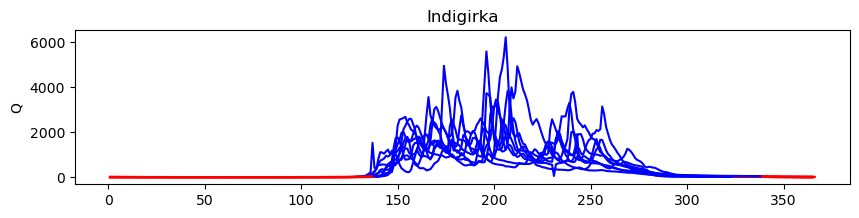

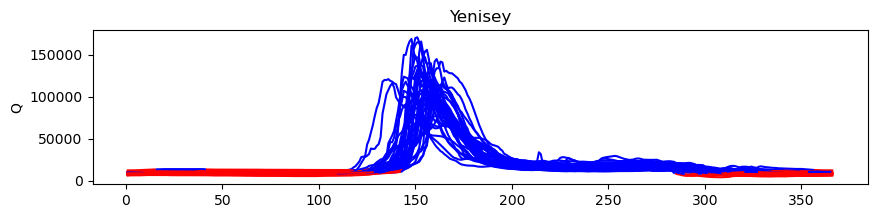

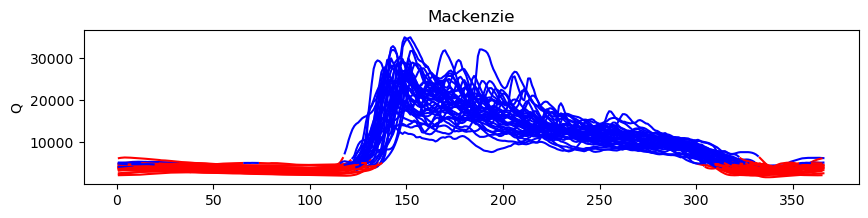

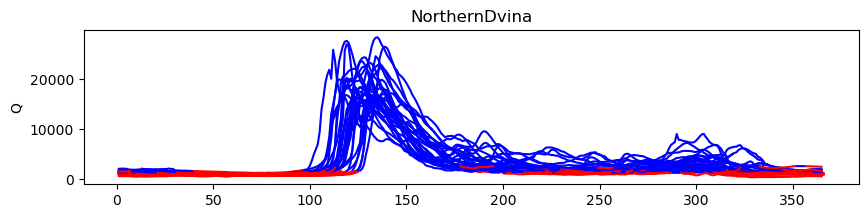

In [23]:
# Try splitting seasonally using Q percentile threshold

for riv in riv_list:
    df = q_dict[riv]
    # df['day'] = df.index.day_of_year
    df['year'] = df.index.year

    fig = plt.figure(figsize=(10, 2))
    ax = fig.add_subplot()

    grouped = df.groupby('year')

    for year, yr_df in grouped:
        if len(yr_df.dropna().index) > 340:
            yr_df.index = yr_df.index.day_of_year

            # Work out threshold within each year (take account of inter-year drift)
            quantile_thresh = yr_df.iloc[:, 0].quantile(q=0.45)

            # Plot discharge. Use iloc as not all columns are called 'discharge'
            # yr_df.iloc[:, 0].plot(ax=ax, legend=False)  # For plotting without seasonal split

            s = yr_df.iloc[:, 0]
            s.mask(s > quantile_thresh).plot(ax=ax, legend=False, color='red')
            s.mask(s <= quantile_thresh).plot(ax=ax, legend=False, color='blue')

        plt.xlabel('')
        plt.ylabel('Q')
        plt.title(riv)

Because of drift over  time and winter low flows sometimes being higher than summer low flows, this doesn't look good. I tried a few different thresholds, but without getting a satisfactory split. Instead, decide to use a simple time window approach, dividing into just summer vs winter depending on day of the year. To decide on what threshold days of the year should be for this seasonal split, for now I (a) started by looking at the graphs above for each river, and then (b) adjusting these by looking at the CQ regressions (notebook 07a) to see at what times of year and associated Q values the water source changes significantly. This is a bit ad hoc, ignores interannual variability, and assumes no longer-term trend. However, the plots below suggest it's ok for most years. For now it is certainly quicker than trying to come up with a clever rule base. But if we want to extrapolate this approach spatially, I would need to come up with something better (but we don't want to do this for now).

In [42]:
# Day-of-year based seasonal split

# For each river, manually decide on [day of year when winter ends, day of year when summer ends]
q_season_dict = {'Kolyma': [140, 290],
                 'Lena': [140, 300],
                 'Ob': [110, 320],
                 'Yukon': [125, 320],
                 'Yenisey': [130, 185],
                 'Mackenzie': [125, 310],
                 'NorthernDvina': [105, 345]}
q_season_df = pd.DataFrame.from_dict(data=q_season_dict, columns=['start', 'end'], orient='index')
q_season_df.to_csv(define_season_df_fpath, index_label='river')

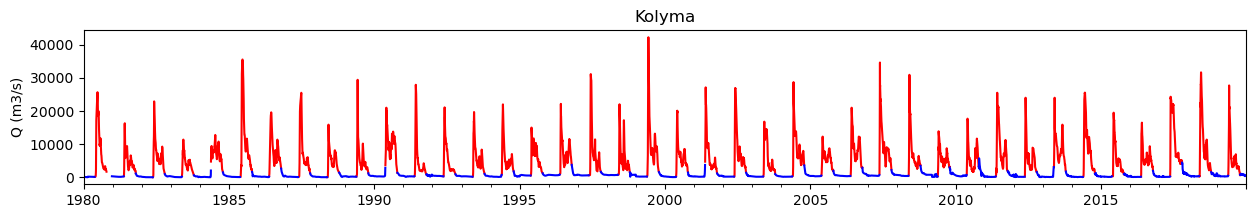

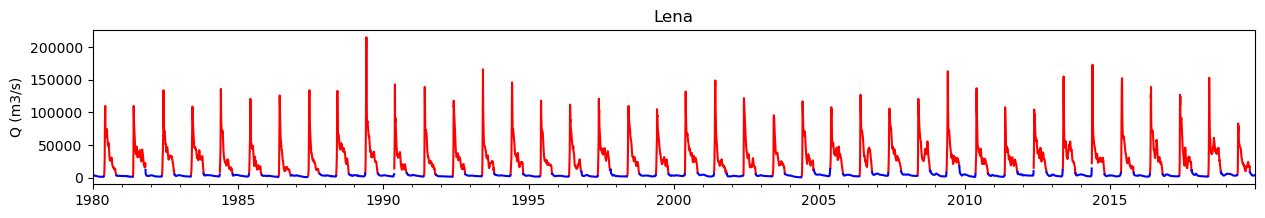

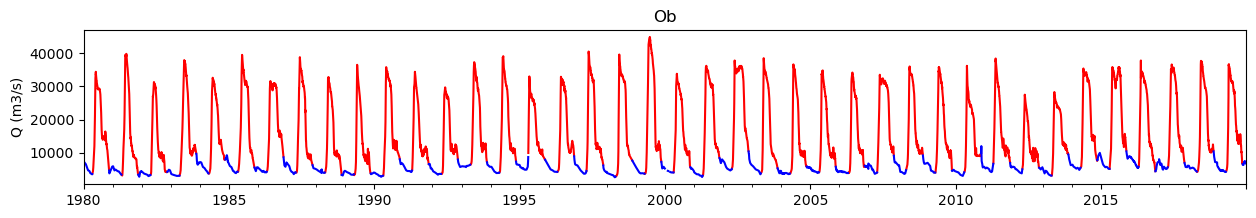

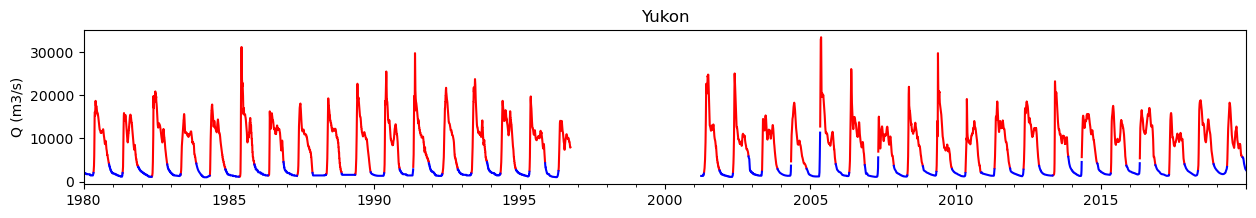

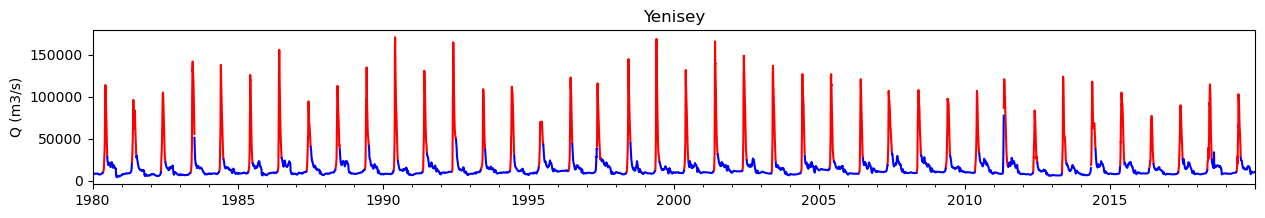

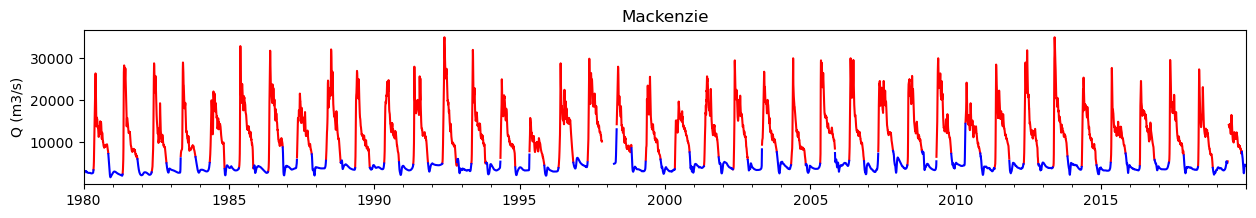

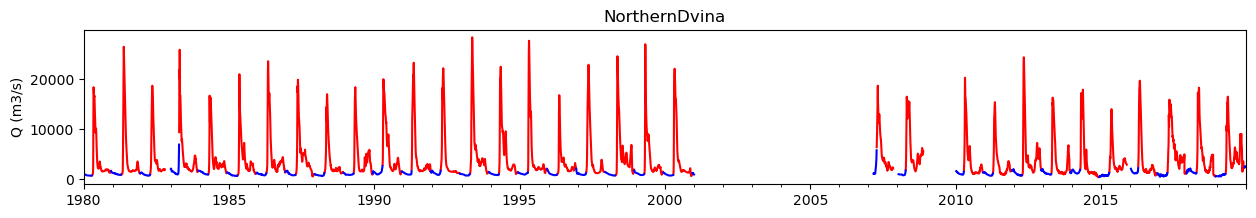

In [43]:
# Plot full time series with this season split to check looks ok &
# that there are no long-termr trends in season length

for river in q_season_dict.keys():
    df = q_dict[river].copy()
    df.columns = ['Q', 'year']
    df['doy'] = df.index.day_of_year
    wint_mask = df['doy'].between(q_season_df.loc[river]['start'],
                                  q_season_df.loc[river]['end'])
    df_wint = df.mask(wint_mask)
    df_summ = df.mask(~wint_mask)

    fig = plt.figure(figsize=(15, 2))
    ax = plt.subplot(111)
    df_summ['Q'].plot(ax=ax, color='red')
    df_wint['Q'].plot(ax=ax, color='blue')
    plt.title(river)
    plt.xlabel('')
    plt.ylabel('Q (m3/s)')